## Table of Contents

### 1. Data Preparation 
- 1.1 Combine Train Features and Targets  
- 1.2 Add Dummy Target Columns to Test Data
- 1.3 Create Train/Validation Split
- 1.4 Merge Train, Validation, and Test Sets

### 2. Feature Engineering  
- 2.1 Basic Cleaning and Binning 
- 2.2 List-Based Feature Engineering
- 2.3 Handling Missing Values  
- 2.4 Derived Numerical Features and Ratios 
- 2.5 EDA Analysis
- 2.6 External Data Integration 
- 2.7 Text Feature Engineering

### 3. Final Dataset Preparation  
- 3.1 Drop Raw Text and Redundant Fields  
- 3.2 One-Hot Encoding of Categorical Features 
- 3.3 Splitting Final Dataset

### 4. Model Training and Feature Selection  
- 4.1 Different Models Used on the Dataset 
- 4.2 Greedy Feature Selection using TPR Optimization 
- 4.3 Visualizing Feature Count vs. TPR
- 4.4 Final Model Training and Evaluation  
- 4.5 Hyperparameter Tuning with Threshold Tracking  

### 5. Test Set Prediction and Submission
- 5.1 Checking performance for best parameter set 
- 5.2 Retrain model on entire training data and making prediction on test

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

import re
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
!pip install textblob
from textblob import TextBlob

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve
from copy import deepcopy
import time
from sklearn.model_selection import ParameterSampler

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanachenreddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanachenreddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 1. Data Preparation
We begin by loading the training and test data, combining targets, and preparing a train/validation split.

In [2]:
# Reading in the datasets
train_x = pd.read_csv('./airbnb_train_x.csv')
train_y = pd.read_csv('./airbnb_train_y.csv')
test_x = pd.read_csv('./airbnb_test_x.csv')

### 1.1 Combine Train Features and Targets
We start by joining `train_x` and `train_y` into a single DataFrame and converting the classification targets (`perfect_rating_score` and `high_booking_rate`) to categorical data types. This simplifies modeling later.

In [3]:
# Combine features and target labels into one training dataframe
train = pd.concat([train_x, train_y], axis=1)

# Convert target variables to categorical for classification
train['perfect_rating_score'] = train['perfect_rating_score'].astype('category')
train['high_booking_rate'] = train['high_booking_rate'].astype('category')

# Show schema and summary
print(train.info())
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92067 entries, 0 to 92066
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       92048 non-null  object  
 1   summary                    88816 non-null  object  
 2   space                      72442 non-null  object  
 3   description                92048 non-null  object  
 4   experiences_offered        92067 non-null  object  
 5   neighborhood_overview      62428 non-null  object  
 6   notes                      45747 non-null  object  
 7   transit                    64335 non-null  object  
 8   access                     58404 non-null  object  
 9   interaction                56661 non-null  object  
 10  house_rules                64234 non-null  object  
 11  host_name                  91898 non-null  object  
 12  host_since                 91898 non-null  object  
 13  host_location              9165

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,...,availability_60,availability_90,availability_365,first_review,license,jurisdiction_names,cancellation_policy,features,high_booking_rate,perfect_rating_score
count,92048,88816,72442,92048,92067,62428,45747,64335,58404,56661,...,92067.000000,92067.000000,92067.000000,92067,8148,45081,92067,92041,92067,92067
unique,90781,85231,69691,90398,1,56360,41178,58282,52677,50267,...,NaN,NaN,NaN,2566,2877,25,6,119,2,2
top,Private room,"My place is good for couples, solo adventurers...",Every booking is instantly confirmed. Every ca...,"My place is good for couples, solo adventurers...",none,La Jolla California is an enchanting seaside c...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,All of our properties utilize our streamlined ...,"Our concierge is available by phone, email, or...",...,NaN,NaN,NaN,2017-01-01,City registration pending,"City of Los Angeles, CA",strict,"Host Has Profile Pic,Host Identity Verified,Is...",NO,NO
freq,12,64,68,36,92067,42,149,134,94,72,...,NaN,NaN,NaN,449,4621,14356,43312,29807,73405,65620
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.783516,41.474405,179.691410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.320198,32.314087,137.535477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,7.000000,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.000000,42.000000,169.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.000000,71.000000,322.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 Add Dummy Target Columns to Test Data

Since the test set doesn't contain labels, we add placeholder columns so it matches the train set schema. We also add a `sample` column to track origin (train/test).


In [4]:
# Add dummy target values to test set so it aligns with train
test = test_x.copy()
test['perfect_rating_score'] = "NO"
test['high_booking_rate'] = "NO"

# Identify sample origin for future split
train["sample"] = "train"
test["sample"] = "test"

print(train.shape)
print(test.shape)

(92067, 64)
(10000, 64)


### 1.3 Create Train/Validation Split

We split the training set into `train_fold` and `valid_fold` using stratified sampling based on the target. This simulates unseen data for evaluation and encoding.

In [5]:
# Split train into train_fold and valid_fold for model tuning and out-of-fold encoding
train_fold, valid_fold = train_test_split(
    train, test_size=0.3, stratify=train["perfect_rating_score"], random_state=42
)

# Label these subsets for downstream transformations
train_fold["sample"] = "train_fold"
valid_fold["sample"] = "valid_fold"

print(train_fold.shape)
print(valid_fold.shape)

(64446, 64)
(27621, 64)


### 1.4 Merge Train, Validation, and Test Sets

We combine all sets into a single `combined_df` to apply preprocessing steps consistently across the entire dataset.

In [6]:
# Join train_fold, valid_fold, and test into one DataFrame for shared transformation
combined_df = pd.concat([train_fold, valid_fold, test], ignore_index=True)

# Confirm distribution of data segments
combined_df["sample"].value_counts()

sample
train_fold    64446
valid_fold    27621
test          10000
Name: count, dtype: int64

## 2. Feature Engineering

This section transforms raw variables into useful formats for modeling. We apply cleaning, encoding, aggregation, and derived features from both categorical and numerical inputs.

### 2.1 Basic Cleaning and Binning

We standardize and simplify raw categorical and numerical fields:
- Host acceptance rate bucketed into `ALL`, `SOME`, and `MISSING`
- Rare `market`, `neighborhood_group`, and `city` values grouped into `OTHER`
- `bed_type` simplified into `bed` or `other`
- Fee-related columns converted to binary flags
- `host_since` and `first_review` converted to "months since" format for modeling recency

In [7]:
# Clean and convert host acceptance rate
combined_df['host_acceptance_rate'] = combined_df['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
combined_df["host_acceptance"] = np.where(combined_df["host_acceptance_rate"] == 1, "ALL",
                                     np.where(combined_df["host_acceptance_rate"] < 1, "SOME","MISSING"))
print(f"host_acceptance count: \n{combined_df['host_acceptance'].value_counts()}\n")

# Standardize state codes to uppercase
combined_df["state"] = combined_df["state"].str.upper()
print(f"State count: \n{combined_df['state'].value_counts()}\n")

# Combine rare 'market' values into 'OTHER'
combined_df["market"] = combined_df["market"].fillna("OTHER")
combined_df["market_instances"] = combined_df.groupby("market")["market"].transform("count")
combined_df["market"] = np.where(combined_df["market_instances"] < 300, "OTHER", combined_df["market"])
combined_df["market"] = np.where(combined_df["market"] == "Other (Domestic)", "OTHER", combined_df["market"])
combined_df["market"] = combined_df["market"].astype("category")
combined_df = combined_df.drop(columns=["market_instances"])
print(f"market count: \n{combined_df['market'].value_counts()}\n")

# Combine rare neighborhood_group entries into 'Other neighborhoods'
combined_df["neighborhood_group"] = combined_df["neighborhood_group"].fillna("Other neighborhoods")
combined_df["neighborhood_group_instances"] = combined_df.groupby("neighborhood_group")["neighborhood_group"].transform("count")
combined_df["neighborhood_group"] = np.where(combined_df["neighborhood_group_instances"] < 300, "Other neighborhoods", combined_df["neighborhood_group"])
combined_df["neighborhood_group"] = combined_df["neighborhood_group"].astype("category")
combined_df = combined_df.drop(columns=["neighborhood_group_instances"])
print(f"neighborhood_group count: \n{combined_df['neighborhood_group'].value_counts()}\n")

# Combine rare cities into 'OTHER'
combined_df["city"] = combined_df["city"].fillna("OTHER")
combined_df["city_instances"] = combined_df.groupby("city")["city"].transform("count")
combined_df["city"] = np.where(combined_df["city_instances"] < 1000, "OTHER", combined_df["city"])
combined_df["city"] = combined_df["city"].astype("category")
combined_df = combined_df.drop(columns=["city_instances"])
print(f"city count: \n{combined_df['city'].value_counts()}\n")

# Simplify bed_type into 'bed' vs 'other'
print(combined_df["bed_type"].value_counts())
print(f"bed_type counts: \n{combined_df['bed_type'].value_counts()}\n")
combined_df["bed_type"] = np.where(combined_df["bed_type"] == "Real Bed", "bed", "other")
print(f"bed_type counts: \n{combined_df['bed_type'].value_counts()}\n")

# Binary flags for fee-related features
combined_df["has_security_deposit"] = np.where(combined_df["security_deposit"] > 0, "YES", "NO")
print(f"has_security_deposit counts:\n {combined_df['has_security_deposit'].value_counts()}\n")

combined_df["has_cleaning_fee"] = np.where(combined_df["cleaning_fee"] > 0, "YES", "NO")
print(f"has_cleaning_fee counts:\n {combined_df['has_cleaning_fee'].value_counts()}\n")

combined_df["charges_for_extra"] = np.where(combined_df["extra_people"] > 0, "YES", "NO")
print(f"charges_for_extra counts:\n {combined_df['charges_for_extra'].value_counts()}\n")

combined_df["has_host_verification"] = np.where(combined_df["host_verifications"].isna(), "NO", "YES")
print(f"has_host_verification counts:\n {combined_df['has_host_verification'].value_counts()}\n")

combined_df["has_min_nights"] = np.where(combined_df["minimum_nights"] > 1, "YES", "NO")
print(f"has_min_nights count: \n{combined_df['has_min_nights'].value_counts()}\n")

combined_df["has_min_nights"] = np.where(combined_df["minimum_nights"] > 1, "YES", "NO")
print(f"has_min_nights count: \n{combined_df['has_min_nights'].value_counts()}\n")

# Convert host_since and first_review to number of months since most recent entry
combined_df['host_since'] = pd.to_datetime(combined_df['host_since'], errors='coerce')
latest_host_since = combined_df['host_since'].max()
combined_df['host_months_since'] = ((latest_host_since - combined_df['host_since']).dt.days / 30.44).round(1)
print(f"Distribution of host_months_since:\n {combined_df['host_months_since'].describe()}\n")

combined_df['first_review'] = pd.to_datetime(combined_df['first_review'], errors='coerce')
latest_first_review = combined_df['first_review'].max()
combined_df['first_review_months'] = ((latest_first_review - combined_df['first_review']).dt.days / 30.44).round(1)
print(f"Distribution of first_review_months:\n {combined_df['first_review_months'].describe()}\n")

host_acceptance count: 
host_acceptance
MISSING    86498
ALL         8799
SOME        6770
Name: count, dtype: int64

State count: 
state
CA    36855
NY    30827
TX     5942
DC     5563
LA     4494
IL     4470
OR     3206
WA     3171
MA     2772
TN     2766
CO     1982
MD       19
Name: count, dtype: int64

market count: 
market
New York           30711
Los Angeles        22963
San Francisco       6636
Austin              5925
D.C.                5559
New Orleans         4482
Chicago             4451
San Diego           4308
Portland            3187
Seattle             3171
Boston              2765
Nashville           2755
Denver              1976
OTHER               1295
East Bay, CA        1290
Monterey Region      593
Name: count, dtype: int64

neighborhood_group count: 
neighborhood_group
Other neighborhoods    70193
Manhattan              14589
Brooklyn               12708
Queens                  2871
Bronx                    471
Capitol Hill             460
Downtown              

### 2.2 List-Based Feature Engineering

We extract structured features from list-type text columns such as `features`, `amenities`, and `host_verifications`.
- Count number of items in each list
- Create binary columns for popular items (e.g., `amenity_tv`, `feature_profile_picture`)
- Group sparse amenities and drop low-fill features (<5% coverage)

In [8]:
# Count number of verifications for listings with host_verification
combined_df['num_verifications'] = np.where(combined_df["has_host_verification"] == "YES", combined_df['host_verifications'].str.count(',') + 1,0)
print(f"Distribution of num_verifications:\n {combined_df['num_verifications'].describe()}\n")

# Features
# Count number of listing features          
combined_df['num_features'] = combined_df['features'].str.count(',') + 1
print(f"Distribution of num_features:\n {combined_df['num_features'].describe()}\n")

# Split 'features' column into a list and identify all unique feature names across the dataset
combined_df['features_list'] = combined_df['features'].dropna().str.split(',') 
unique_features = set()
combined_df['features_list'].dropna().apply(unique_features.update)
print(sorted(unique_features))

# Create binary indicator column for each feature
for method in unique_features:
    combined_df[method] = combined_df['features_list'].apply(
        lambda x: int(isinstance(x, list) and method in x))
    print(combined_df[method].value_counts())

# Amenities
# Clean and split 'amenities' into lists; Clean up spacing and capitalization in each amenity for consistent comparison
combined_df['amenities_list'] = combined_df['amenities'].fillna('').str.strip('{}').str.split(',')

combined_df['num_amenities'] = combined_df['amenities_list'].apply(len)
print(f"Distribution of num_amenities:\n {combined_df['num_amenities'].describe()}\n")

combined_df['amenities_list'] = combined_df['amenities_list'].apply(
    lambda lst: [item.strip().lower() for item in lst])

# Define and create grouped binary flags for popular amenity categories
amenity_groups = {
    'free_parking': ['free parking on premises'],
    'pets_allowed': ['pets allowed'],
    'checkin_24hr': ['24-hour check-in', '24 hour check-in', 'self check-in']}
for new_col, keywords in amenity_groups.items():
    combined_df[new_col] = combined_df['amenities_list'].apply(
        lambda lst: int(any(keyword in lst for keyword in keywords)))
    print(combined_df[new_col].value_counts())

# Extract all unique amenity names across listings
unique_amenities = set()
combined_df['amenities_list'].dropna().apply(unique_amenities.update)
print(f"Total unique amenities: {len(unique_amenities)}")
print(sorted(unique_amenities))

for amenity in unique_amenities:
    col_name = f"amenity_{amenity.strip().replace(' ', '_').replace('-', '_')}"
    combined_df[col_name] = combined_df['amenities_list'].apply(
        lambda x: int(isinstance(x, list) and amenity in x)
    )
    print(f"{col_name}:")
    print(combined_df[col_name].value_counts())

# Drop amenity columns that appear in less than 5% of rows
threshold = 0.05 * len(combined_df)
amenity_cols = [col for col in combined_df.columns if col.startswith('amenity_')]
amenity_presence = combined_df[amenity_cols].sum()
low_fill_amenities = amenity_presence[amenity_presence < threshold].index.tolist()
combined_df.drop(columns=low_fill_amenities, inplace=True)
print(f"Dropped {len(low_fill_amenities)} low-fill amenity columns.")

amenity_cols = [col for col in combined_df.columns if col.startswith('amenity_')]
amenity_cols

Distribution of num_verifications:
 count    102067.000000
mean          4.429865
std           1.165253
min           0.000000
25%           4.000000
50%           4.000000
75%           5.000000
max          14.000000
Name: num_verifications, dtype: float64

Distribution of num_features:
 count    102035.000000
mean          3.277121
std           1.033326
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           8.000000
Name: num_features, dtype: float64

['Host Has Profile Pic', 'Host Identity Verified', 'Host Is Superhost', 'Instant Bookable', 'Is Location Exact', 'Require Guest Phone Verification', 'Require Guest Profile Picture', 'Requires License']
Require Guest Phone Verification
0    96878
1     5189
Name: count, dtype: int64
Host Is Superhost
0    79488
1    22579
Name: count, dtype: int64
Require Guest Profile Picture
0    98092
1     3975
Name: count, dtype: int64
Host Identity Verified
1    77872
0    24195
Name: count, dty

['amenity_wheelchair_accessible',
 'amenity_suitable_for_events',
 'amenity_lock_on_bedroom_door',
 'amenity_fire_extinguisher',
 'amenity_laptop_friendly_workspace',
 'amenity_wireless_internet',
 'amenity_hair_dryer',
 'amenity_gym',
 'amenity_pets_live_on_this_property',
 'amenity_pets_allowed',
 'amenity_first_aid_kit',
 'amenity_self_check_in',
 'amenity_family/kid_friendly',
 'amenity_breakfast',
 'amenity_translation_missing:_en.hosting_amenity_49',
 'amenity_essentials',
 'amenity_air_conditioning',
 'amenity_smoke_detector',
 'amenity_24_hour_check_in',
 'amenity_safety_card',
 'amenity_kitchen',
 'amenity_heating',
 'amenity_hangers',
 'amenity_iron',
 'amenity_hot_tub',
 'amenity_washer',
 'amenity_translation_missing:_en.hosting_amenity_50',
 'amenity_tv',
 'amenity_private_entrance',
 'amenity_lockbox',
 'amenity_free_parking_on_premises',
 'amenity_elevator_in_building',
 'amenity_internet',
 'amenity_indoor_fireplace',
 'amenity_dryer',
 'amenity_cable_tv',
 'amenity_buz

### 2.3 Handling Missing Values

We handle missing data as follows:
- Fill `cleaning_fee` and `price` with 0
- Impute missing `first_review_months` and `host_months_since` with 0
- Impute numerical features with column means
- Clean `cancellation_policy` by grouping strict variations
- Fill `host_response_time` missing values with "missing"
- Map `property_type` to broader `property_category`

In [9]:
# Replace missing cleaning_fee and price with 0
print(f"Null before cleaning: {combined_df['cleaning_fee'].isna().sum(), combined_df['price'].isna().sum()}\n ")
combined_df["cleaning_fee"] = pd.to_numeric(combined_df["cleaning_fee"], errors="coerce")
combined_df["price"] = pd.to_numeric(combined_df["price"], errors="coerce")
combined_df["cleaning_fee"] = combined_df["cleaning_fee"].fillna(0)
combined_df["price"] = combined_df["price"].fillna(0)
print(f"After cleaning: {combined_df['cleaning_fee'].isna().sum()}, {combined_df['price'].isna().sum()}\n")

# Fill date-based recency features with 0 (interpreted as "unknown")
combined_df['host_months_since'] = combined_df['host_months_since'].fillna(0)
combined_df['first_review_months'] =combined_df['first_review_months'].fillna(0)

# Impute remaining numeric columns with column mean
numeric_cols = combined_df.select_dtypes(include=['number']).columns
combined_df[numeric_cols] = combined_df[numeric_cols].apply(lambda x: x.fillna(x.mean()))

# Group similar cancellation policies
print(f"Cancellation Policy \nCounts before: \n{combined_df['cancellation_policy'].value_counts()}\n")
combined_df["cancellation_policy"] = combined_df["cancellation_policy"].replace("super_strict_30", "strict").replace("super_strict_60", "strict").replace("no_refunds", "strict")
print(f"Counts after: \n{combined_df['cancellation_policy'].value_counts()}\n")

# Replace missing host_response_time with a placeholder category
combined_df["host_response_time"] = combined_df["host_response_time"].fillna("missing")
print(f"host_response_time Counts: \n{combined_df['host_response_time'].value_counts()}\n")

# Create simplified property category
combined_df["property_category"] = np.where(combined_df["property_type"].isin(["Apartment", "Serviced apartment", "Loft"]), "apartment",
                                       np.where(combined_df["property_type"].isin(["Bed & Breakfast", "Boutique hotel", "Hostel"]), "hotel",
                                                np.where(combined_df["property_type"].isin(["Townhouse", "Condominium"]), "condo",
                                                         np.where(combined_df["property_type"].isin(["Bungalow", "House"]), "house", "other"))))
print(f"Counts after: \n{combined_df['property_category'].value_counts()}\n")

Null before cleaning: (np.int64(22323), np.int64(585))
 
After cleaning: 0, 0

Cancellation Policy 
Counts before: 
cancellation_policy
strict             48019
moderate           30005
flexible           23737
super_strict_30      197
super_strict_60      104
no_refunds             5
Name: count, dtype: int64

Counts after: 
cancellation_policy
strict      48325
moderate    30005
flexible    23737
Name: count, dtype: int64

host_response_time Counts: 
host_response_time
within an hour        50884
within a few hours    21439
missing               14894
within a day          13174
a few days or more     1676
Name: count, dtype: int64

Counts after: 
property_category
apartment    59297
house        33248
condo         5634
other         2840
hotel         1048
Name: count, dtype: int64



### 2.4 Derived Numerical Features and Ratios
We generate new variables that represent:
- Price per person, per bed, and per combined room
- Ratios of accommodations to amenities, beds to bedrooms, etc.
- Host availability and responsiveness, such as:
  - `host_response_rate * availability_365`
  - `host_response_rate * num_verifications`
  - `host_experience = response_rate * host_months_since`
  - `host_experience_load = host_months_since / listings_count`
- Host Proximity Feature: We engineer a binary variable `host_nearby` that is 1 if:
    - The host's `host_neighbourhood` matches `neighborhood`
    - OR `city` appears in `host_location`
    - OR `market` appears in `host_location`

In [10]:
# Price per person and per room-type
combined_df["price_per_person"] = combined_df["price"] / combined_df["accommodates"]
print(f"Distribution of num_verifications:\n {combined_df['price_per_person'].describe()}\n")

combined_df["price_per_bed"] = combined_df["price"] / (combined_df["beds"] + 1)
print(f"Distribution of price_per_bed:\n {combined_df['price_per_bed'].describe()}\n")

combined_df["price_per_bedroom"] = combined_df["price"] / (combined_df["bedrooms"] + 1)
print(f"Distribution of price_per_bedroom:\n {combined_df['price_per_bedroom'].describe()}\n")

combined_df["price_per_bed_plus_bath"] = combined_df["price"] / (combined_df["bedrooms"] + combined_df["bathrooms"] + 1)
print(f"Distribution of price_per_bed_plus_bath:\n {combined_df['price_per_bed_plus_bath'].describe()}\n")

# Booking cost including other charges
combined_df["complete_price"] = (combined_df["price"] + combined_df["security_deposit"] + combined_df["cleaning_fee"])

# Beds and bathrooms per room
combined_df["beds_per_bedrooms"] = combined_df["beds"] / (combined_df["bedrooms"] + 1)
print(f"Distribution of beds_per_bedrooms:\n {combined_df['beds_per_bedrooms'].describe()}\n")

combined_df["bathrooms_per_accommodates"] = combined_df["bathrooms"] / combined_df["accommodates"]
print(f"Distribution of bathrooms_per_accommodates:\n {combined_df['bathrooms_per_accommodates'].describe()}\n")

combined_df["bathrooms_per_bedrooms"] = combined_df["bathrooms"] / (combined_df["bedrooms"] + 1)
print(f"Distribution of bathrooms_per_bedrooms:\n {combined_df['bathrooms_per_bedrooms'].describe()}\n")

combined_df["bedrooms_per_accommodates"] = combined_df["bedrooms"] / combined_df["accommodates"]
print(f"Distribution of bedrooms_per_accommodates:\n {combined_df['bedrooms_per_accommodates'].describe()}\n")

# accommodates * num_amenities: More people + more amenities could mean higher satisfaction.
combined_df["accommodates_into_num_amenities"] = combined_df["num_amenities"] * combined_df["accommodates"]
print(f"Distribution of accommodates x num_amenities:\n {combined_df['accommodates_into_num_amenities'].describe()}\n")

# Host behavior and verification metrics
# host_response_rate * availability_365: More responsive + more available = better user experience.
combined_df["host_response_rate_into_availability_365"] = combined_df["host_response_rate"] * combined_df["availability_365"]
print(f"Distribution of host_response_rate_into_availability_365:\n {combined_df['host_response_rate_into_availability_365'].describe()}\n")

# host_response_rate * num_verifications: More responsive + more available = better user experience.
combined_df["host_response_rate_into_num_verifications"] = combined_df["host_response_rate"] * combined_df["num_verifications"]
print(f"Distribution of host_response_rate_into_num_verifications:\n {combined_df['host_response_rate_into_num_verifications'].describe()}\n")

# host_experience_grade is a measurement of host's experience and responsiveness
combined_df["host_experience"] = (combined_df["host_response_rate"] * combined_df["host_months_since"])

# availability_experience combines availability with the experience and responsiveness of the host
combined_df["availability_experience"] = (combined_df["availability_365"] * combined_df["host_experience"])

# host_acceptance_rate * host_total_listings_count: Indicates professionalism or experience.
combined_df["host_acceptance_rate_into_listings_count"] = combined_df["host_acceptance_rate"] * combined_df["host_total_listings_count"]
print(f"Distribution of host_acceptance_rate_into_listings_count:\n {combined_df['host_acceptance_rate_into_listings_count'].describe()}\n")

# host_acceptance_rate * host_total_listings_count: Indicates professionalism or experience.
combined_df["num_verifications_into_listings_count"] = combined_df["num_verifications"] * combined_df["host_total_listings_count"]
print(f"Distribution of num_verifications_into_listings_count:\n {combined_df['num_verifications_into_listings_count'].describe()}\n")

# Response Time × Response Rate - Fast and responsive hosts are likely to receive more bookings.
# Convert to numeric scale (map text to speed score)
response_time_map = {'within an hour': 4, 'within a few hours': 3,
    'within a day': 2, 'a few days or more': 1}

combined_df['response_speed'] = combined_df['host_response_time'].map(response_time_map).fillna(0)
print(f"Distribution of response_speed:\n {combined_df['response_speed'].describe()}\n")

combined_df['host_responsiveness'] = combined_df['response_speed'] * combined_df['host_response_rate'].fillna(0)
print(f"Distribution of host_responsiveness:\n {combined_df['host_responsiveness'].describe()}\n")

# Host Experience Load - Long-time host but with too many listings = divided attention.
combined_df['host_experience_load'] = combined_df['host_months_since'] / (combined_df['host_listings_count'] + 1)

# Host Proximity Feature
combined_df['host_neighbourhood_norm'] = combined_df['host_neighbourhood'].fillna('').str.strip().str.lower()
combined_df['neighborhood_norm'] = combined_df['neighborhood'].fillna('').str.strip().str.lower()
combined_df['host_location_norm'] = combined_df['host_location'].fillna('').str.strip().str.lower()
combined_df['city_norm'] = combined_df['city'].astype(str).fillna('').str.strip().str.lower()
combined_df['market_norm'] = combined_df['market'].astype(str).fillna('').str.strip().str.lower()

neigh_match = combined_df['host_neighbourhood_norm'] == combined_df['neighborhood_norm']
city_match = combined_df.apply(lambda row: row['city_norm'] in row['host_location_norm'], axis=1)
market_match = combined_df.apply(lambda row: row['market_norm'] in row['host_location_norm'], axis=1)

combined_df['host_nearby'] = np.where(neigh_match | city_match | market_match, 1, 0)
print(f"host_nearby Counts: \n{combined_df['host_nearby'].value_counts()}\n")

Distribution of num_verifications:
 count    102067.000000
mean         46.431372
std          29.465320
min           0.000000
25%          28.166667
50%          40.000000
75%          57.000000
max         980.000000
Name: price_per_person, dtype: float64

Distribution of price_per_bed:
 count    102067.000000
mean         51.447789
std          32.540468
min           0.000000
25%          30.000000
50%          44.500000
75%          62.500000
max         499.500000
Name: price_per_bed, dtype: float64

Distribution of price_per_bedroom:
 count    102067.000000
mean         63.133311
std          43.690527
min           0.000000
25%          35.000000
50%          50.000000
75%          79.000000
max         929.000000
Name: price_per_bedroom, dtype: float64

Distribution of price_per_bed_plus_bath:
 count    102067.000000
mean         39.904515
std          25.246627
min           0.000000
25%          23.000000
50%          33.333333
75%          50.000000
max         450.000000


### 2.5 EDA Analysis

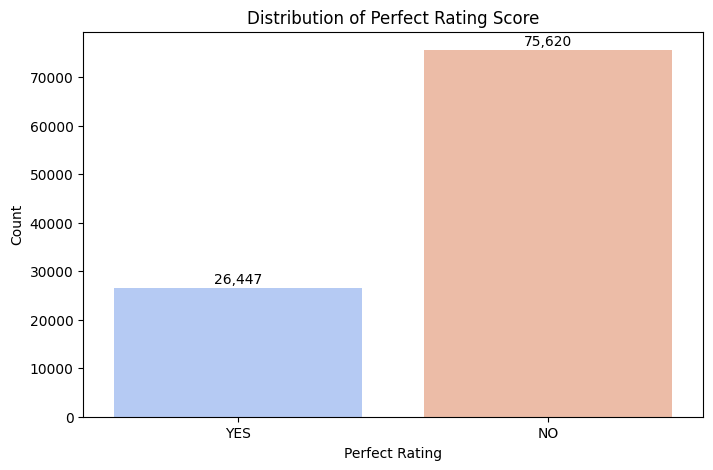

In [11]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=combined_df, x='perfect_rating_score', palette='coolwarm')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1000, f'{int(height):,}', ha="center")

plt.title('Distribution of Perfect Rating Score')
plt.xlabel('Perfect Rating')
plt.ylabel('Count')
plt.show()

The bar chart shows a clear class imbalance in the target variable `perfect_rating_score`:

“NO” dominates with 75,620 listings

“YES” has significantly fewer instances, nearly 26,447

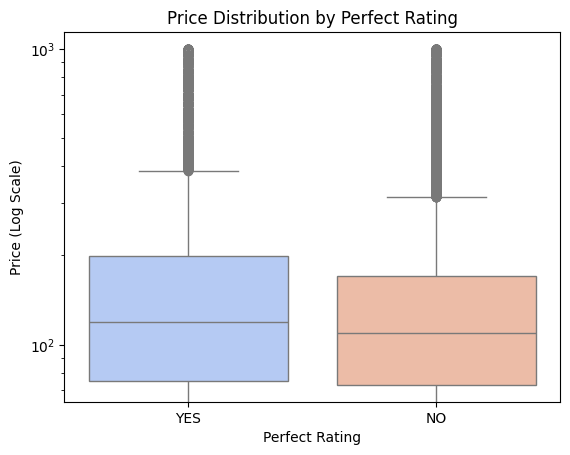

In [12]:
# Price Distribution
sns.boxplot(data=combined_df, x="perfect_rating_score", y="price",palette='coolwarm')
plt.yscale("log")
plt.title("Price Distribution by Perfect Rating")
plt.xlabel("Perfect Rating")
plt.ylabel("Price (Log Scale)")
plt.show()

Listings with and without a perfect rating have similar price distributions, with both showing long tails of high-priced outliers. This suggests that `price` alone doesn't drive perfect ratings, and other factors like amenities or host behavior likely matter more

perfect_rating_score        NO       YES
has_cleaning_fee                        
NO                    0.696716  0.303284
YES                   0.753271  0.246729


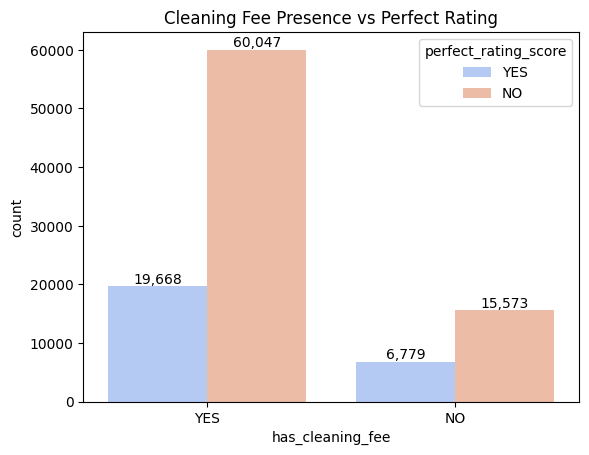

In [13]:
# Cleaning fee
#Tabular Form 
print (pd.crosstab(combined_df["has_cleaning_fee"], combined_df["perfect_rating_score"], normalize='index'))

# Graphical Form 
ax = sns.countplot(data=combined_df, x="has_cleaning_fee", hue="perfect_rating_score", palette='coolwarm')
plt.title("Cleaning Fee Presence vs Perfect Rating")

for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.text(p.get_x() + p.get_width() / 2., height + 500, f'{int(height):,}', ha="center")
plt.show()

While listings with a `cleaning_fee` are more frequent, those without a `cleaning_fee` have a higher proportion of perfect ratings, suggesting that avoiding extra fees may improve guest satisfaction

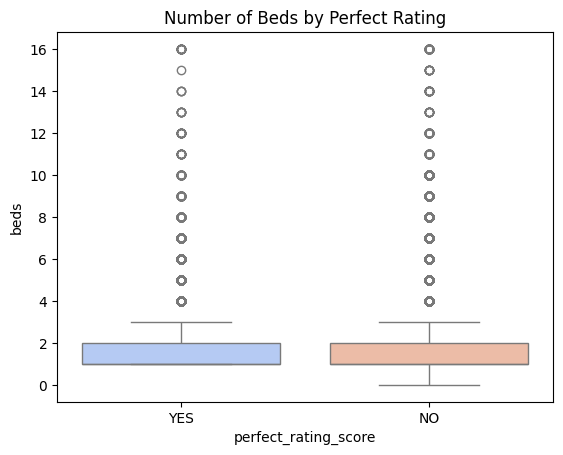

In [14]:
# Beds
sns.boxplot(data=combined_df, x="perfect_rating_score", y="beds",palette='coolwarm')
plt.title("Number of Beds by Perfect Rating")
plt.show()

Number of Beds by Perfect Rating : The distribution of `beds` is nearly identical for both groups. Most listings offer one or two beds regardless of rating. Hence, bed count alone doesn't significantly influence perfect ratings

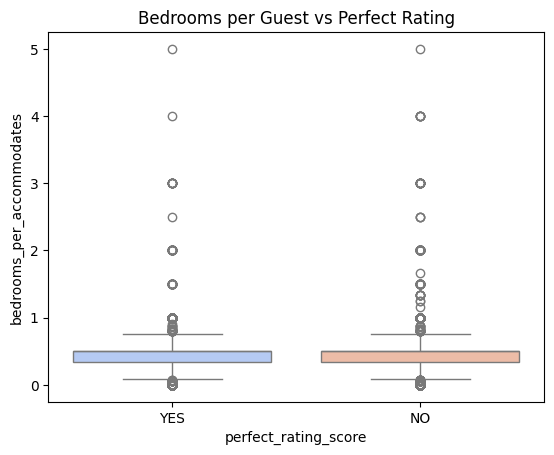

In [15]:
# Bedrooms per guest
sns.boxplot(data=combined_df, x="perfect_rating_score", y="bedrooms_per_accommodates", palette='coolwarm')
plt.title("Bedrooms per Guest vs Perfect Rating")
plt.show()

Bedrooms per Guest vs Perfect Rating: Both rating groups have similar `bedrooms_per_accommodates` ratios, clustering between 0.25 and 0.5. This suggests that space per guest isn’t a strong differentiator for perfect ratings

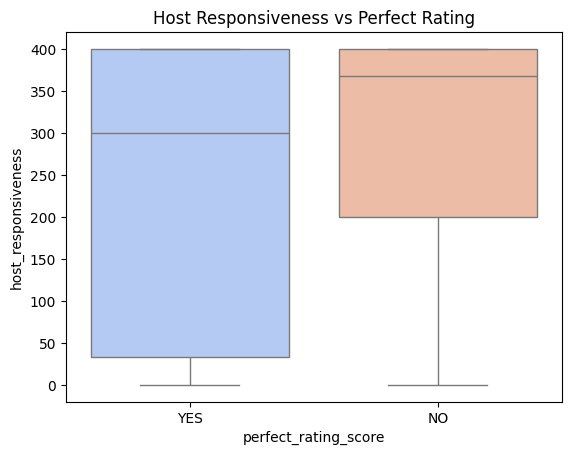

In [16]:
# Host responsiveness
sns.boxplot(data=combined_df, x="perfect_rating_score", y="host_responsiveness",palette='coolwarm')
plt.title("Host Responsiveness vs Perfect Rating")
plt.show()

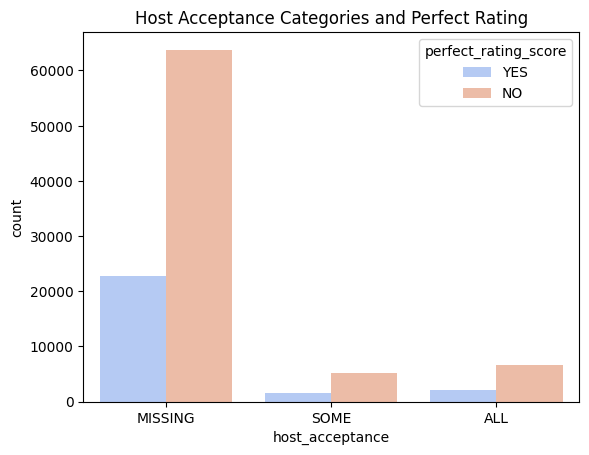

In [17]:
# Acceptance categories
sns.countplot(data=combined_df, x="host_acceptance", hue="perfect_rating_score",palette='coolwarm')
plt.title("Host Acceptance Categories and Perfect Rating")
plt.show()

Huge number of listings have missing values for the `host_acceptance` field, yet they still account for a considerable volume of perfect ratings. This may indicate that:

-Many hosts likely accept most requests without explicitly setting acceptance rules, leading to a good guest experience even if the field is blank

-The missing data may reflect system defaults, older listings, or hosts who never updated optional profile sections, not necessarily poor hosting standards

Meanwhile, listings that explicitly declare “ALL” or “SOME” acceptance do not show a strong distinction in perfect rating share, suggesting that the presence of acceptance data doesn’t automatically equate to better guest outcomes.

perfect_rating_score        NO       YES
market                                  
Austin                0.646582  0.353418
D.C.                  0.720813  0.279187
San Diego             0.726555  0.273445
San Francisco         0.742616  0.257384
Los Angeles           0.742717  0.257283
New York              0.751685  0.248315
New Orleans           0.754351  0.245649
Chicago               0.762750  0.237250
Seattle               0.773888  0.226112
Portland              0.785378  0.214622


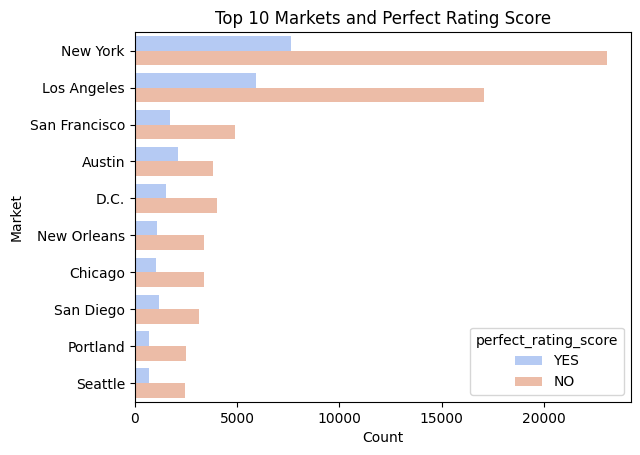

In [18]:
# market
top_markets = combined_df["market"].value_counts().nlargest(10).index
subset = combined_df[combined_df["market"].isin(top_markets)]

proportion_table = pd.crosstab(subset["market"], subset["perfect_rating_score"], normalize='index')
proportion_table = proportion_table.sort_values(by="YES", ascending=False)
print(proportion_table)

top_markets = combined_df["market"].value_counts().nlargest(10).index
subset = combined_df[combined_df["market"].isin(top_markets)]
subset["market"] = pd.Categorical(subset["market"], categories=top_markets, ordered=True)

sns.countplot(data=subset, y="market", hue="perfect_rating_score", order=top_markets, palette='coolwarm')
plt.title("Top 10 Markets and Perfect Rating Score")
plt.xlabel("Count")
plt.ylabel("Market")
plt.show()

While Los Angeles & New York dominate in listing volume, cities like Austin and D.C. show a higher proportion of perfect ratings. In contrast, markets like Portland and Seattle have the lowest share of perfect scores. This suggests that guest satisfaction varies by market

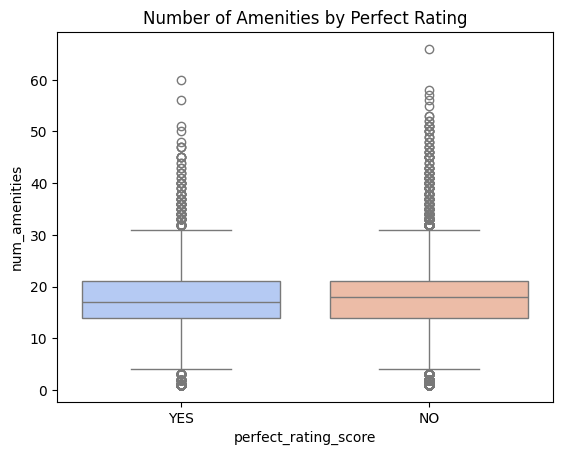

In [19]:
# Number of amenities
sns.boxplot(data=combined_df, x="perfect_rating_score", y="num_amenities", palette='coolwarm')
plt.title("Number of Amenities by Perfect Rating")
plt.show()

Listings with perfect ratings tend to have a slightly higher median number of amenities compared to those without. While the difference isn't large, it suggests that providing more amenities may contribute positively to guest satisfaction

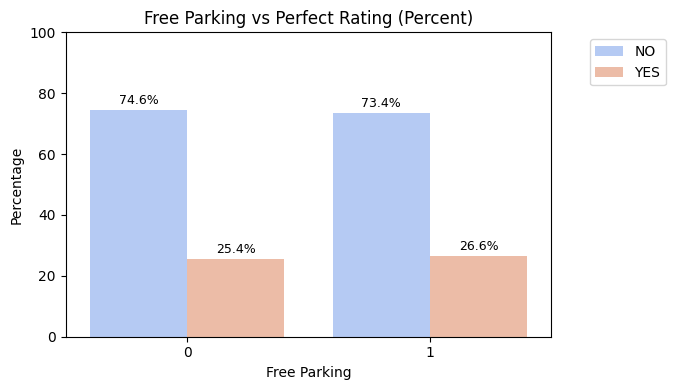

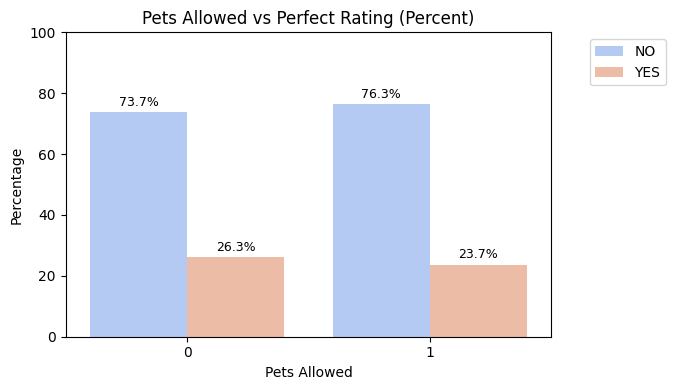

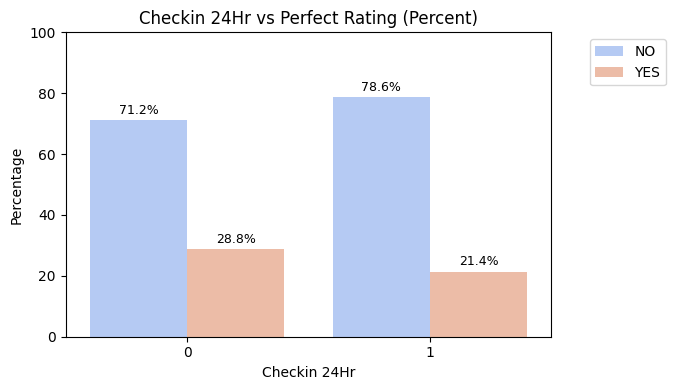

In [20]:
key_amenities = ['free_parking', 'pets_allowed', 'checkin_24hr']

for col in key_amenities:
    pct_df = pd.crosstab(combined_df[col], combined_df["perfect_rating_score"], normalize='index') * 100
    pct_df = pct_df.reset_index().melt(id_vars=col, value_name="Percentage", var_name="perfect_rating_score")

    plt.figure(figsize=(7, 4))
    ax = sns.barplot(data=pct_df, x=col, y="Percentage", hue="perfect_rating_score", palette='coolwarm')
    plt.title(f"{col.replace('_', ' ').title()} vs Perfect Rating (Percent)")
    plt.ylabel("Percentage")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylim(0, 100)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height + 2,
                f'{height:.1f}%',
                ha="center",
                fontsize=9
            )

    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

    plt.tight_layout()
    plt.show()

Free Parking: Perfect rating proportion is slightly higher when free parking is available (26.6% vs 25.4%). The difference is small but may signal added guest convenience

Pets Allowed: Listings not allowing pets have a higher share of perfect ratings (26.3% vs 23.7%). Pet-friendly listings might bring more variables (noise, cleanliness), affecting guest satisfaction

24-Hour Check-in: Contrary to expectation, listings without 24-hour check-in have a higher proportion of perfect ratings (28.8% vs 21.4%). It could be because 24-hour check-in listings are often automated, high-turnover rentals where convenience replaces personalized service.

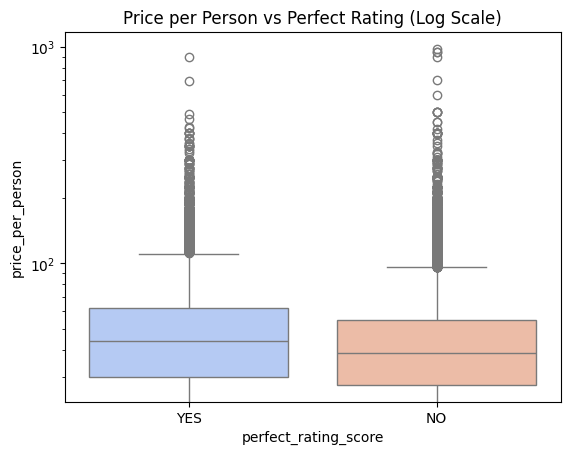

In [21]:
sns.boxplot(data=combined_df, x="perfect_rating_score", y="price_per_person", palette='coolwarm')
plt.yscale("log")
plt.title("Price per Person vs Perfect Rating (Log Scale)")
plt.show()

The log-scaled plot shows that listings with perfect ratings generally have a slightly lower median `price_per_person` compared to those without. However, both distributions have long tails with expensive outliers, indicating that while affordability may help, high prices don’t necessarily prevent perfect ratings if value is delivered.

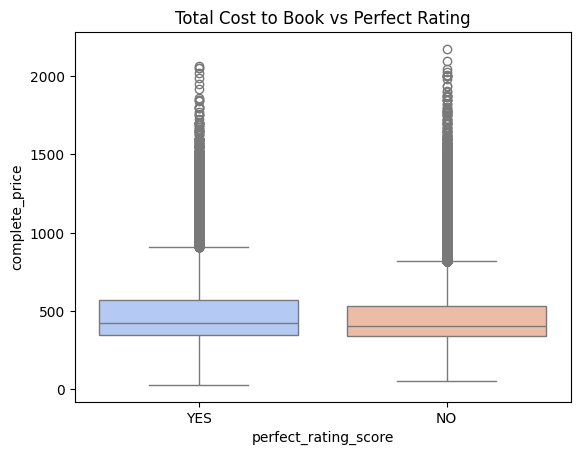

In [22]:
# Complete price
sns.boxplot(data=combined_df, x="perfect_rating_score", y="complete_price",palette='coolwarm')
plt.title("Total Cost to Book vs Perfect Rating")
plt.show()

The distribution of `complete_price`(total booking cost) is very similar between listings with and without perfect ratings. Both groups exhibit a wide range of prices with several high outliers, suggesting that total cost alone does not strongly differentiate highly-rated listings.

In [23]:
print("Min months since host joined:", combined_df["host_months_since"].min())
print("Max months since host joined:", combined_df["host_months_since"].max())

Min months since host joined: 0.0
Max months since host joined: 110.5


Proportion of Perfect Ratings by Host Experience Bin:


perfect_rating_score,NO,YES
host_experience_bin,,
0–1 yr,0.652712,0.347288
1–3 yrs,0.730372,0.269628
3–5 yrs,0.759756,0.240244
5–7 yrs,0.786518,0.213482
7+ yrs,0.831525,0.168475


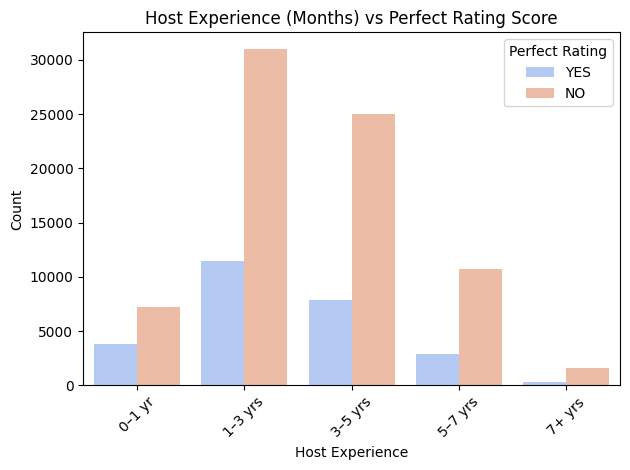

In [24]:
# host_months_since
bins = [0, 12, 36, 60, 84, 110.5]
labels = ["0–1 yr", "1–3 yrs", "3–5 yrs", "5–7 yrs", "7+ yrs"]

combined_df["host_experience_bin"] = pd.cut(
    combined_df["host_months_since"], bins=bins, labels=labels, include_lowest=True
)

#Tabular form 
host_bin_crosstab = pd.crosstab(
    combined_df['host_experience_bin'],
    combined_df['perfect_rating_score'],
    normalize='index'
)
print("Proportion of Perfect Ratings by Host Experience Bin:")
display(host_bin_crosstab)

#graphical representation
sns.countplot(data=combined_df, x="host_experience_bin", hue="perfect_rating_score", palette='coolwarm')
plt.title("Host Experience (Months) vs Perfect Rating Score")
plt.xlabel("Host Experience")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Perfect Rating")
plt.tight_layout()
plt.show()

There is a clear decline in the proportion of perfect ratings as host experience increases. Hosts with less than a year of experience have the highest share of perfect ratings (34.7%), while those with over 7 years drop to just 16.8% possibly because newer hosts tend to put in extra effort to impress guests and build a strong reputation early on. Also, recent listings may be more updated/aligned with current guest preferences, while more experienced hosts might become complacent over time, leading to slightly lower ratings.

In [25]:
# Proportion of perfect ratings by host verification status
verification_crosstab = pd.crosstab(
    combined_df["has_host_verification"], 
    combined_df["perfect_rating_score"], 
    normalize='index'
)
print("Proportion of Perfect Ratings by Host Verification:")
display(verification_crosstab)

Proportion of Perfect Ratings by Host Verification:


perfect_rating_score,NO,YES
has_host_verification,,
NO,0.789189,0.210811
YES,0.740798,0.259202


The table indicates that around 25% of listings with host verification received perfect ratings, compared to only 21.1% for non-verified hosts. This indicates that host verification may contribute positively to guest trust and satisfaction. This could be due to perceived legitimacy or safety. While the difference is small, verified hosts appear slightly more likely to earn perfect ratings.

### 2.6 External Data Integration

We enhance the dataset with additional geographic context using external sources.

In this case, we integrate **crime rate data** from Kaggle by merging it with our dataset using the `state` column. This provides macro-level safety information that may influence guest ratings or preferences.

In [26]:
crime_df = pd.read_csv('./kaggle_crimedata.csv')

In [27]:
# Merge crime data into the train set by state
combined_df = combined_df.merge(crime_df, on='state', how='left')

In [28]:
combined_df["Crime Incidents"].describe()

count    102067.000000
mean       5328.096290
std        2663.717548
min         143.000000
25%        5932.000000
50%        5932.000000
75%        6784.000000
max        9036.000000
Name: Crime Incidents, dtype: float64

### 2.7 Text Feature Engineering

We process several free-text columns using **TF-IDF** (Term Frequency–Inverse Document Frequency) to identify and flag the presence of informative terms.
- Identify all relevant text-heavy columns (e.g., `summary`, `description`, `house_rules`)
- Apply TF-IDF to generate sparse term-weight matrices
- Optionally flag the presence of specific manually chosen words or themes (e.g., `"quiet"`, `"near subway"`)

This captures qualitative information that may influence ratings but is not reflected in numeric or categorical fields.

In [29]:
text_cols = ['access','description','host_about','house_rules','interaction','name',
    'neighborhood_overview','notes','space','summary','transit']

In [30]:
combined_df[text_cols].isna().sum()

access                   37384
description                 21
host_about               30835
house_rules              30921
interaction              39349
name                        20
neighborhood_overview    32873
notes                    51378
space                    21781
summary                   3590
transit                  30769
dtype: int64

In [31]:
# Make sure text columns have no missing values
for col in text_cols:
    combined_df[col] = combined_df[col].fillna("").astype(str)

##### Manual Selection code

In [32]:
def combine_text_columns(df, text_cols):
    return df[text_cols].fillna("").agg(" ".join, axis=1)

def extract_top_tfidf_words(df_train, text_cols, top_n=100):
    combined_text = combine_text_columns(df_train, text_cols)

    vectorizer = TfidfVectorizer(
        stop_words='english', 
        max_features=5000, 
        ngram_range=(1,2) 
        )
    X_tfidf = vectorizer.fit_transform(combined_text)

    tfidf_scores = zip(vectorizer.get_feature_names_out(), X_tfidf.sum(axis=0).A1)
    top_words = sorted(tfidf_scores, key=lambda x: -x[1])[:top_n]

    return [word for word, score in top_words], vectorizer

def add_tfidf_ngram_flags(df, text_cols, terms, prefix='tfidf'):
    combined_text = df[text_cols].fillna("").agg(" ".join, axis=1).str.lower()

    for term in terms:
        col_name = f"{prefix}_{term.replace(' ', '_')}"
        df[col_name] = combined_text.apply(lambda x: int(term in x))
    
    return df

In [33]:
# Step 1: Combine and extract top words
df_train = combined_df[combined_df["sample"] == "train_fold"].copy()
df_valid = combined_df[combined_df["sample"] == "valid_fold"].copy()
df_test = combined_df[combined_df["sample"] == "test"].copy()

top_tfidf_words, tfidf_vectorizer = extract_top_tfidf_words(df_train, text_cols, top_n=200)

# Print and manually filter
print("Top TF-IDF Words:")
print(top_tfidf_words)

Top TF-IDF Words:
['apartment', 'room', 'bedroom', 'house', 'home', 'private', 'kitchen', 'walk', 'place', 'bed', 'park', 'street', 'away', 'great', 'neighborhood', 'new', 'guests', 'restaurants', 'space', 'living', 'located', 'access', 'downtown', 'bathroom', 'close', 'minutes', 'city', 'just', 'area', 'parking', 'blocks', 'available', 'beach', 'quiet', 'love', 'large', 'stay', 'walking', 'living room', 'building', 'queen', 'location', 'floor', 'enjoy', 'beautiful', 'distance', 'll', 'train', 'clean', 'free', 'bus', 'bars', 'walking distance', 'tv', 'block', 'use', 'guest', 'minute', '10', 'studio', 'coffee', 'people', 'like', 'size', 'hollywood', 'need', 'manhattan', 'time', 'comfortable', 'min', 'spacious', 'subway', 'check', 'best', 'easy', 'brooklyn', 'cozy', 'heart', 'good', 'shops', 'bath', 'right', 'unit', 'center', 'east', 'dining', 'central', 'station', 'perfect', 'la', 'wifi', 'shared', 'san', 'modern', 'live', 'square', 'fully', 'austin', 'make', 'light', 'line', '15', 'min

In [34]:
selected_terms = [
    # Cleanliness & comfort
    'clean', 'quiet', 'cozy', 'comfortable', 'spacious', 'modern', 'renovated', 'safe', 'private', 'new', 'large', 'plenty'

    # Amenities
    'wifi', 'tv', 'washer', 'dryer', 'kitchen', 'bathroom', 'queen', 'queen size', 'shared'
    'pool', 'laundry', 'cable', 'air', 'furnished', 'towels', 'living room', 'queen',

    # Location & access
    'walk', 'walking', 'walking distance', 'blocks away', 'minute walk',
    'bus', 'metro', 'train', 'subway', 'station', 'transportation', 'easy'
    'street parking', 'parking', 'access', 'central', 'downtown', 'minutes', 'city',

    # Host vibe & tone
    'welcome', 'enjoy', 'amazing', 'friendly', 'best', 'perfect', 'good', 'great', 'view', 'beautiful', 'light','love',
    'nice', 'welcoming', 'helpful', 'responsive', 'heart', 'historic', 'available', 'free', 'best',

    # Lifestyle & audience
    'restaurants', 'bars', 'coffee', 'shops', 'loft', 'studio', 'patio', 'garden', 'dining', 'shopping'
    'solo adventurers', 'local', 'neighborhood', 'art', 'music', 'park', 'downtown','close', 'beach', 'garden'
]

In [35]:
combined_df = add_tfidf_ngram_flags(combined_df, text_cols, selected_terms)

The following commented-out blocks were used to do automatic feature selection from the 10,000 tfidf columns created. But we found that the manual selection worked better. We retained the following cells for evaluation.

#### 2.6.1.1 TF-IDF Token Matrix Construction

To prepare for token-based feature selection using LightGBM, we:
1. Combine relevant text columns into a single string per row.
2. Use `TfidfVectorizer` to build a sparse matrix of token frequencies.
3. Limit the feature space to the top `n` tokens (default: 10,000) across unigrams and bigrams.

This allows LightGBM to later select a subset (e.g., 200 tokens) that are most informative for predicting the target.

In [36]:
# def combine_text_columns(df, text_cols):
#     """
#     Combine all selected text columns into one space-separated string per row.
#     Missing values are replaced with empty strings.
#     """
#     return df[text_cols].fillna("").agg(" ".join, axis=1)

# def extract_tfidf_matrix(df, text_cols, top_n=10000):
#     """
#     Convert the combined text into a sparse TF-IDF matrix.
#     - Uses English stopwords
#     - Extracts both unigrams and bigrams
#     - Limits vocabulary to top_n tokens (default 10,000)
#     """
#     combined_text = combine_text_columns(df, text_cols)
    
#     vectorizer = TfidfVectorizer(
#         stop_words='english', 
#         max_features=top_n, 
#         ngram_range=(1, 2)
#     )
#     X_tfidf = vectorizer.fit_transform(combined_text)
    
#     return X_tfidf, vectorizer

In [37]:
# # Extract TF-IDF matrix from training set
# df_train = combined_df[combined_df["sample"] == "train_fold"].copy()
# df_valid = combined_df[combined_df["sample"] == "valid_fold"].copy()
# df_test = combined_df[combined_df["sample"] == "test"].copy()

# X_tfidf_train, tfidf_vectorizer = extract_tfidf_matrix(df_train, text_cols, top_n=10000)

#### 2.6.1.2 Selecting Informative Tokens with LightGBM

Once the TF-IDF matrix is created, we train a LightGBM classifier to predict `perfect_rating_score`.

We then extract the top N most important tokens (e.g., 200) from the full 10,000-token vocabulary. These selected tokens are used as predictive features in the final model.

In [38]:
# # Prepare target variable
# y_train = [1 if x == 'YES' else 0 for x in df_train['perfect_rating_score']]

# # Train LightGBM to find token importance
# xgb_selector = xgb.XGBClassifier(
#     max_depth=4,
#     colsample_bytree=0.1,
#     subsample=0.8,
#     n_estimators=100,
#     tree_method='hist',
#     verbosity=1,
#     n_jobs=-1,
#     random_state=42
# )

# xgb_selector.fit(top_tfidf_words, y_train)

# importances = xgb_selector.feature_importances_

# # Select top 200 important tokens
# top_200_indices = np.argsort(importances)[-200:]
# top_200_tokens = np.array(tfidf_vectorizer.get_feature_names_out())[top_200_indices]

# print(f"Selected top {len(top_200_tokens)} important tokens.")

In [39]:
# # Get feature importance values for top 200 tokens
# top_200_importances = importances[top_200_indices]

# # Create a DataFrame
# top_200_tokens_df = pd.DataFrame({
#     "token": top_200_tokens,
#     "importance": top_200_importances
# })

# # Sort by importance
# top_200_tokens_df = top_200_tokens_df.sort_values(by="importance", ascending=False)

# top_200_tokens_df.head(20)  # See most important tokens

#### 2.6.1.3 Finalize TF-IDF Token Features

After selecting the top 200 tokens using LightGBM, we:
1. Recompute the full TF-IDF matrix using the combined dataset
2. Extract only the selected top 200 tokens
3. Prefix the token names with `tfidf_` for clarity
4. Merge these sparse TF-IDF features back into `combined_df`

These token columns are now available for modeling alongside other engineered features.

In [40]:
# # 1. Combine all selected text columns into one text field
# def combine_text_columns(df, text_cols):
#     """
#     Combine multiple text columns into a single string per row.
#     """
#     return df[text_cols].fillna("").astype(str).agg(" ".join, axis=1)

# combined_text_full = combine_text_columns(combined_df, text_cols)

# # 2. Transform using the previously trained TF-IDF vectorizer
# X_tfidf_full = tfidf_vectorizer.transform(combined_text_full)

# # 3. Convert TF-IDF matrix to a sparse DataFrame
# X_tfidf_full_df = pd.DataFrame.sparse.from_spmatrix(
#     X_tfidf_full,
#     columns=tfidf_vectorizer.get_feature_names_out()
# )

# # 4. Select only the top 200 tokens from earlier model selection
# X_tfidf_top200_df = X_tfidf_full_df[top_200_tokens]

# # 5. Rename columns with a tfidf_ prefix
# X_tfidf_top200_df.columns = [f"tfidf_{col.replace(' ', '_')}" for col in top_200_tokens]

# # 6. Merge selected token columns into the full dataset
# combined_df = pd.concat([combined_df.reset_index(drop=True), X_tfidf_top200_df.reset_index(drop=True)], axis=1)

# print(f"Added {X_tfidf_top200_df.shape[1]} TF-IDF token columns to combined_df!")

In [41]:
# pd.set_option('display.max_columns', None)
# print(combined_df.columns.tolist())

In [42]:
# # Identify all TF-IDF token columns based on naming convention
tfidf_cols = [col for col in combined_df.columns if col.startswith('tfidf_')]

# Compute the total count of selected keywords present in each listing's text
# (i.e., number of non-zero tfidf-weighted tokens across the selected top 200)
combined_df["tfidf_keyword_count"] = combined_df[tfidf_cols].sum(axis=1)

In [43]:
combined_df["tfidf_keyword_count"] = combined_df["tfidf_keyword_count"].astype(float)
combined_df["tfidf_keyword_count"].describe()

count    102067.000000
mean         23.709985
std           9.771699
min           0.000000
25%          17.000000
50%          24.000000
75%          31.000000
max          63.000000
Name: tfidf_keyword_count, dtype: float64

#### 2.6.2 Verbosity Feature

We define a `verbosity_score` as the total number of characters across all relevant text columns for each listing. This provides a continuous measure of how detailed or verbose a host's description is.

A higher score may reflect more thorough listings, which could positively impact guest perceptions and ratings.

In [44]:
def calculate_verbosity(df, text_cols):
    # Combine all text columns into one and count total words
    df["verbosity_word_count"] = df[text_cols].fillna("").agg(" ".join, axis=1).str.split().apply(len)
    return df

combined_df = calculate_verbosity(combined_df, text_cols)

In [45]:
df_train = combined_df[combined_df["sample"] == "train_fold"].copy()
df_valid = combined_df[combined_df["sample"] == "valid_fold"].copy()
df_test = combined_df[combined_df["sample"] == "test"].copy()

scaler = MinMaxScaler()
scaler.fit(df_train[["verbosity_word_count"]])

combined_df["verbosity_scaled"] = scaler.transform(combined_df[["verbosity_word_count"]]).clip(0, 1)

In [46]:
combined_df[["verbosity_word_count","verbosity_scaled"]].describe()

,verbosity_word_count,verbosity_scaled
count,102067.000000,102067.000000
mean,501.657862,0.156712
std,278.039128,0.087379
min,0.000000,0.000000
25%,294.000000,0.091452
50%,487.000000,0.152106
75%,671.000000,0.209931
max,3185.000000,1.000000


#### 2.6.3 Sentiment Feature Engineering

We apply VADER sentiment analysis to key listing text fields to capture emotional tone.
Each text is scored on a polarity scale from -1 (very negative) to +1 (very positive).
Sentiment features extracted:
- `description_sentiment`
- `summary_sentiment`
- `house_rules_sentiment`
- `host_about_sentiment`
- `interaction_sentiment`

We use the raw sentiment scores as continuous inputs to the model. We plot the variable to understand relation between sentiment and `perfect_rating_score`

In [47]:
# Define function for sentiment analysis
def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity  # Range: [-1.0, 1.0]
    except:
        return 0.0

In [48]:
# Applying fucntion on the text columns
for col in ["description", "summary", "house_rules", "host_about","interaction"]:
    combined_df[f"{col}_sentiment"] = combined_df[col].apply(get_sentiment)

In [49]:
combined_df[["description_sentiment","summary_sentiment","house_rules_sentiment", "host_about_sentiment","interaction_sentiment"]].describe()

,description_sentiment,summary_sentiment,house_rules_sentiment,host_about_sentiment,interaction_sentiment
count,102067.000000,102067.000000,102067.000000,102067.000000,102067.000000
mean,0.264658,0.279647,0.107613,0.196588,0.164220
std,0.116628,0.176389,0.176593,0.196483,0.219022
min,-0.700000,-0.800000,-1.000000,-1.000000,-0.800000
25%,0.193435,0.166667,0.000000,0.000000,0.000000
50%,0.259699,0.275000,0.000000,0.194056,0.000000
75%,0.329931,0.385366,0.200000,0.339118,0.337121
max,1.000000,1.000000,1.000000,1.000000,1.000000


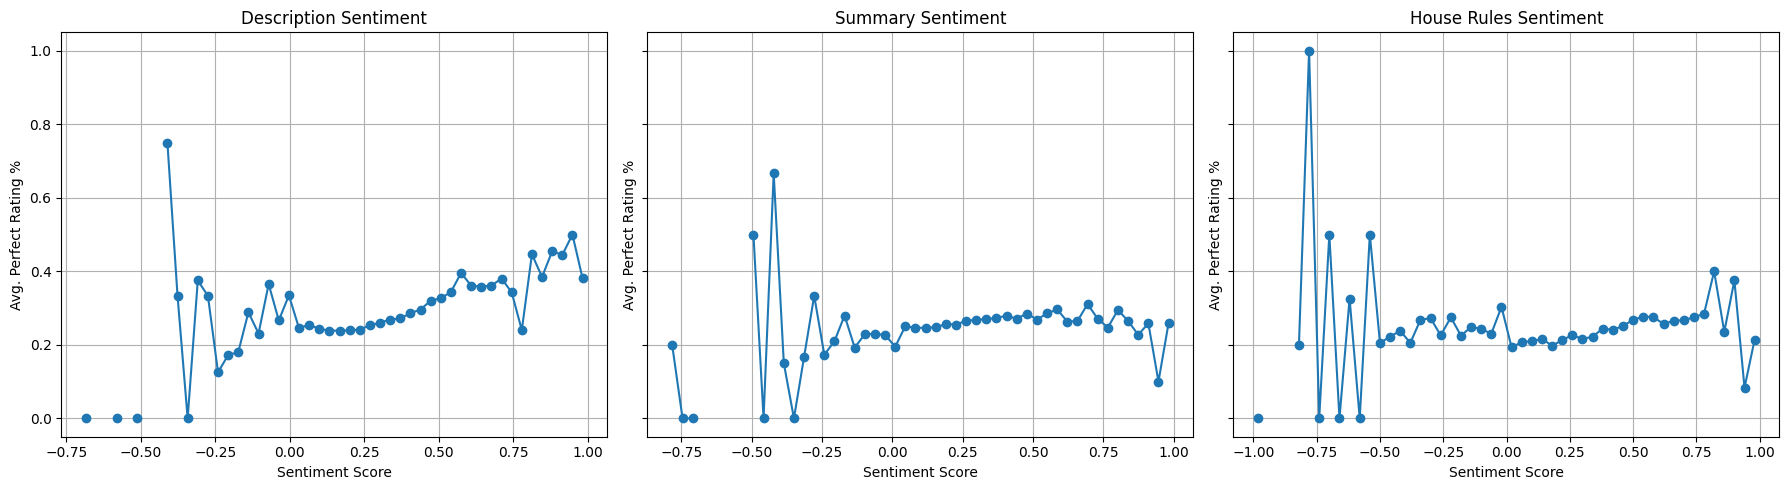

In [50]:
combined_df["perfect_rating_score_binary"] = (combined_df["perfect_rating_score"] == "YES").astype(int)
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sentiment_fields = ["description_sentiment", "summary_sentiment", "house_rules_sentiment"]
titles = ["Description Sentiment", "Summary Sentiment", "House Rules Sentiment"]

for i, field in enumerate(sentiment_fields):
    binned = pd.cut(combined_df[field], bins=50)
    grouped = combined_df.groupby(binned)["perfect_rating_score_binary"].mean()

    bin_centers = [interval.left + (interval.right - interval.left)/2 for interval in grouped.index]

    axs[i].plot(bin_centers, grouped.values, marker='o')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Sentiment Score")
    axs[i].set_ylabel("Avg. Perfect Rating %")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

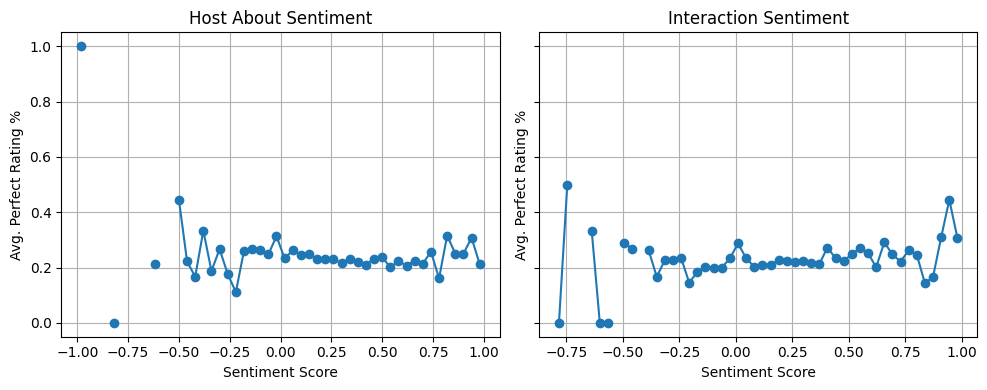

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sentiment_fields = ["host_about_sentiment", "interaction_sentiment"]
titles = ["Host About Sentiment", "Interaction Sentiment"]

for i, field in enumerate(sentiment_fields):
    binned = pd.cut(combined_df[field], bins=50)
    grouped = combined_df.groupby(binned)["perfect_rating_score_binary"].mean()

    bin_centers = [interval.left + (interval.right - interval.left)/2 for interval in grouped.index]

    axs[i].plot(bin_centers, grouped.values, marker='o')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Sentiment Score")
    axs[i].set_ylabel("Avg. Perfect Rating %")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## 3. Final Dataset Preparation

We finalize the dataset for modeling by:
- Removing intermediate columns used for preprocessing
- Dropping raw text, high-cardinality, or sparsely used fields
- Applying one-hot encoding to categorical variables
- Splitting into train, validation, and test sets

### 3.1 Drop Raw Text and Redundant Fields

We remove columns that are no longer needed for modeling, including:
- Text columns already processed via TF-IDF or sentiment (e.g., `summary`, `description`)
- Redundant features (e.g., `zipcode`, `street`, `latitude`, `longitude`)
- Raw high-cardinality fields that have been transformed (e.g., `features`, `amenities`, `host_verifications`)
- Normalized helper columns created during proximity or text processing

In [52]:
# Drop raw text and redundant fields that have been transformed or are high-dimensional
columns_to_drop = ['name', 'summary', 'space', 'description', 'experiences_offered','neighborhood_overview', 'notes', 'transit', 'access',
                   'interaction','house_rules', 'host_name', 'host_location', 'host_about', 'host_acceptance_rate', 'host_neighbourhood',
                   'host_verifications','street','neighborhood', 'zipcode', 'smart_location',
                   'country_code', 'country', 'latitude','longitude', 'property_type', 'amenities', 'square_feet', 'weekly_price',
                   'monthly_price', 'license', 'jurisdiction_names','features', 'features_list', 'amenities_list', 'first_review', 
                   'host_since', 'host_neighbourhood_norm', 'neighborhood_norm', 'host_location_norm', 'city_norm',	'market_norm','host_experience_bin']
cleaned_df = combined_df.drop(columns=columns_to_drop, errors='ignore')

# Normalize column names: lowercase and replace spaces with underscores
cleaned_df.columns = cleaned_df.columns.str.lower().str.replace(' ', '_')
print(cleaned_df.columns)

Index(['host_response_time', 'host_response_rate', 'host_listings_count',
       'host_total_listings_count', 'neighborhood_group', 'city', 'state',
       'market', 'room_type', 'accommodates',
       ...
       'tfidf_beach', 'tfidf_keyword_count', 'verbosity_word_count',
       'verbosity_scaled', 'description_sentiment', 'summary_sentiment',
       'house_rules_sentiment', 'host_about_sentiment',
       'interaction_sentiment', 'perfect_rating_score_binary'],
      dtype='object', length=205)


### 3.2 One-Hot Encoding of Categorical Features

We apply one-hot encoding to convert categorical variables into binary indicators for model compatibility.

- We use `ColumnTransformer` and `OneHotEncoder` from scikit-learn
- Drop-first encoding is applied to avoid multicollinearity

In [53]:
# Define all categorical columns for encoding
categorical_cols = ['host_response_time', 'market', 'room_type', 'bed_type', 'cancellation_policy', 'high_booking_rate',
       'perfect_rating_score', 'host_acceptance','has_security_deposit', 'has_cleaning_fee', 'charges_for_extra',
       'has_host_verification', 'has_min_nights','property_category', 'city', 'neighborhood_group', 'state']
categorical_cols

# Create a column transformer that applies one-hot encoding to categorical columns
ct = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Transform and convert back to DataFrame
transformed_df = ct.fit_transform(cleaned_df)
final_df = pd.DataFrame(transformed_df, columns=ct.get_feature_names_out())
final_df.columns = final_df.columns.str.replace(" ", "_", regex=False).str.replace(",", "", regex=False)
final_df.head()

,host_response_time_missing,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,market_Boston,market_Chicago,market_D.C.,market_Denver,market_East_Bay_CA,market_Los_Angeles,...,tfidf_beach,tfidf_keyword_count,verbosity_word_count,verbosity_scaled,description_sentiment,summary_sentiment,house_rules_sentiment,host_about_sentiment,interaction_sentiment,perfect_rating_score_binary
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,41.0,690,0.215902,0.351222,0.35,0.5,0.24537,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,22.0,406,0.12665,0.344339,0.389103,0.0,0.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,32.0,634,0.198303,0.284259,0.2375,0.280208,0.345779,0.2875,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,44.0,718,0.224701,0.224892,0.0,0.0,0.0,0.5,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,42.0,1157,0.362665,0.276942,0.299596,0.225,0.380152,0.425,0


In [54]:
print(list(final_df.columns))

['host_response_time_missing', 'host_response_time_within_a_day', 'host_response_time_within_a_few_hours', 'host_response_time_within_an_hour', 'market_Boston', 'market_Chicago', 'market_D.C.', 'market_Denver', 'market_East_Bay_CA', 'market_Los_Angeles', 'market_Monterey_Region', 'market_Nashville', 'market_New_Orleans', 'market_New_York', 'market_OTHER', 'market_Portland', 'market_San_Diego', 'market_San_Francisco', 'market_Seattle', 'room_type_Private_room', 'room_type_Shared_room', 'bed_type_other', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'high_booking_rate_YES', 'perfect_rating_score_YES', 'host_acceptance_MISSING', 'host_acceptance_SOME', 'has_security_deposit_YES', 'has_cleaning_fee_YES', 'charges_for_extra_YES', 'has_host_verification_YES', 'has_min_nights_YES', 'property_category_condo', 'property_category_hotel', 'property_category_house', 'property_category_other', 'city_Boston', 'city_Brooklyn', 'city_Chicago', 'city_Denver', 'city_Los_Angeles', 'city_N

### 3.3 Splitting Final Dataset

We split the fully transformed dataset into:
- `X_train`: training features
- `X_valid`: validation set used for evaluation
- `X_test`: final test set for prediction submission

The split is done based on the `sample` labels assigned earlier in the workflow.

In [55]:
# Split the fully transformed dataset
train_insts = final_df[final_df["sample"]=="train_fold"]
valid_insts = final_df[final_df["sample"]=="valid_fold"]
test_insts = final_df[final_df["sample"]=="test"]

columns_to_drop = ['perfect_rating_score_YES', 'high_booking_rate_YES']
test_insts = test_insts.drop(columns=columns_to_drop, errors = 'ignore')

print(train_insts.shape)
print(valid_insts.shape)
print(test_insts.shape)

(64446, 259)
(27621, 259)
(10000, 257)


In [56]:
# Dropping labels and sample variable from train set
features_to_drop = ['sample','perfect_rating_score_YES' ,'high_booking_rate_YES', 'perfect_rating_score_binary']

# Splitting the samples
X_train = train_insts.drop(columns=features_to_drop, errors='ignore')
y_train = train_insts['perfect_rating_score_YES'].astype(int)
X_valid = valid_insts.drop(columns=features_to_drop, errors='ignore')
y_valid = valid_insts['perfect_rating_score_YES'].astype(int)
X_test = test_insts.drop(columns=features_to_drop, errors='ignore')

## 4. Model Training and Feature Selection
- In 4.1 we run various models to compare and contrast the performance

From 4.2 onwards, we identify the most predictive features and train a binary classification model using XGBoost.
- Apply greedy forward feature selection to maximize True Positive Rate (TPR) while keeping False Positive Rate (FPR) ≤ 10%
- Train a robust model to predict whether a listing receives a perfect rating
- Use only the selected features for final training and evaluation

### 4.1 Different Models used on the Dataset

### 4.1.1 Linear Regression

In [57]:
# Preprocess: numeric-only features
X_train_num = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_valid_num = X_valid.apply(pd.to_numeric, errors='coerce').fillna(0)

X_train_num = X_train_num.dropna(axis=1, how='all')
X_valid_num = X_valid_num[X_train_num.columns]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_valid_scaled = scaler.transform(X_valid_num)

# Convert y to numeric
y_train_num = pd.to_numeric(y_train, errors='coerce')
y_valid_num = pd.to_numeric(y_valid, errors='coerce')

# Train Linear Regression 
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_num)

# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_valid_pred = lr.predict(X_valid_scaled)
r2 = r2_score(y_valid_num, y_valid_pred)
rmse = np.sqrt(mean_squared_error(y_valid_num, y_valid_pred))

print(f"Linear Regression R²:   {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_valid_pred_binary = (y_valid_pred >= threshold).astype(int)

cm = confusion_matrix(y_valid_num, y_valid_pred_binary)
print("\nConfusion Matrix:\n", cm)

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

train_accuracy = accuracy_score(y_train_num, y_train_pred_binary)
valid_accuracy = accuracy_score(y_valid_num, y_valid_pred_binary)

print("\nLinear Regression Results:")
print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Valid Accuracy:  {valid_accuracy:.2%}")
print(f"TPR (Recall): {tpr:.2%}")
print(f"FPR:         {fpr:.2%}")

Linear Regression R²:   0.1844
Linear Regression RMSE: 0.4086

Confusion Matrix:
 [[18380  1307]
 [ 5585  2349]]

Linear Regression Results:
Train Accuracy: 75.33%
Valid Accuracy:  75.05%
TPR (Recall): 29.61%
FPR:         6.64%


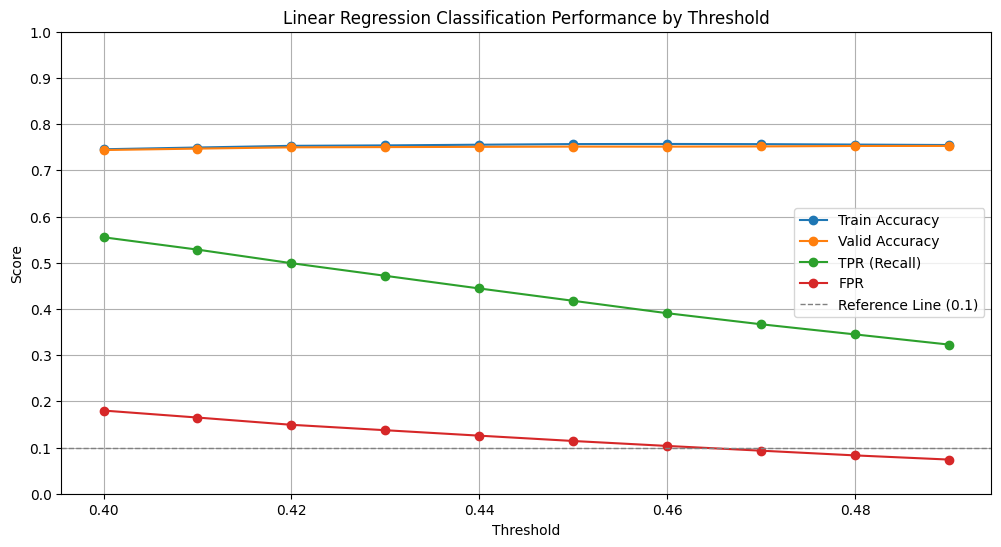

,Threshold,Train Accuracy,Valid Accuracy,TPR (Recall),FPR
0,0.40,0.745570,0.743891,0.555079,0.180017
1,0.41,0.749387,0.747004,0.528359,0.164880
2,0.42,0.753018,0.749756,0.498992,0.149185
3,0.43,0.753949,0.750262,0.471641,0.137451
4,0.44,0.755439,0.750806,0.444290,0.125667
5,0.45,0.756789,0.751349,0.417570,0.114136
6,0.46,0.757052,0.751276,0.390723,0.103418
7,0.47,0.756649,0.751711,0.366776,0.093158
8,0.48,0.755749,0.752688,0.344845,0.082948
9,0.49,0.754771,0.752797,0.322788,0.073907


In [58]:
# Define thresholds
thresholds = np.arange(0.4, 0.5, 0.01)

# Initialize results list
results = []

for threshold in thresholds:
    y_train_pred_binary = (y_train_pred >= threshold).astype(int)
    y_valid_pred_binary = (y_valid_pred >= threshold).astype(int)
    
    valid_acc = accuracy_score(y_valid_num, y_valid_pred_binary)
    train_acc = accuracy_score(y_train_num, y_train_pred_binary)

    cm = confusion_matrix(y_valid_num, y_valid_pred_binary)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    else:
        recall = np.nan
        fpr = np.nan

    results.append({
        'Threshold': threshold,
        'Train Accuracy': train_acc,
        'Valid Accuracy': valid_acc,
        'TPR (Recall)': recall,
        'FPR': fpr
    })

# Convert to DataFrame
lr_threshold_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(lr_threshold_df['Threshold'], lr_threshold_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(lr_threshold_df['Threshold'], lr_threshold_df['Valid Accuracy'], label='Valid Accuracy', marker='o')
plt.plot(lr_threshold_df['Threshold'], lr_threshold_df['TPR (Recall)'], label='TPR (Recall)', marker='o')
plt.plot(lr_threshold_df['Threshold'], lr_threshold_df['FPR'], label='FPR', marker='o')

plt.yticks(np.arange(0.0, 1.05, 0.1))
plt.axhline(0.1, color='gray', linestyle='--', linewidth=1, label='Reference Line (0.1)')

plt.title("Linear Regression Classification Performance by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()
lr_threshold_df

In [59]:
# Creating a function to save results of all models in a dataframe
def save_model_result(results_df, source_df, threshold, model_name):
    """
    Extracts metrics for a given threshold from a source DataFrame and appends them to results_df.
    """
    row = source_df[np.isclose(source_df['Threshold'], threshold)].iloc[0]
    
    result = {
        'Model': model_name,
        'Train Accuracy': row['Train Accuracy'],
        'Test Accuracy': row['Valid Accuracy'],
        'TPR (Recall)': row['TPR (Recall)'],
        'FPR': row['FPR'],
        'Threshold': row['Threshold']
    }

    return pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

In [60]:
# Initialize combined results dataframe
model_results = pd.DataFrame()

# Save Linear Regression results at threshold = 0.47
model_results = save_model_result(model_results, lr_threshold_df, threshold=0.47, model_name="Linear Regression")

# Print the result
last_row = model_results.iloc[-1]
print(f"{last_row['Model']} Final Results:")
print(f"Train Accuracy: {last_row['Train Accuracy']:.2%}")
print(f"Valid Accuracy:  {last_row['Test Accuracy']:.2%}")
print(f"TPR (Recall):   {last_row['TPR (Recall)']:.2%}")
print(f"FPR:            {last_row['FPR']:.2%}")
print(f"Threshold:      {last_row['Threshold']:.2f}")

Linear Regression Final Results:
Train Accuracy: 75.66%
Valid Accuracy:  75.17%
TPR (Recall):   36.68%
FPR:            9.32%
Threshold:      0.47


### 4.1.2 Logistic Regression

In [61]:
# Train Logistic Regression
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train_scaled, y_train_num)

# Predict and evaluate
y_train_pred = lgr.predict(X_train_scaled)
y_valid_pred = lgr.predict(X_valid_scaled)
r2 = r2_score(y_valid_num, y_valid_pred)
rmse = np.sqrt(mean_squared_error(y_valid_num, y_valid_pred))

print(f"Linear Regression R²:   {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

y_train_proba = lgr.predict_proba(X_train_scaled)[:, 1]
y_valid_proba = lgr.predict_proba(X_valid_scaled)[:, 1]

threshold = 0.5
y_train_pred_binary = (y_train_proba >= threshold).astype(int)
y_valid_pred_binary = (y_valid_proba >= threshold).astype(int)

cm = confusion_matrix(y_valid_num, y_valid_pred_binary)
print("\nConfusion Matrix:\n", cm)

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

train_accuracy = accuracy_score(y_train_num, y_train_pred_binary)
valid_accuracy = accuracy_score(y_valid_num, y_valid_pred_binary)

print("\nLogistic Regression Results:")
print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Valid Accuracy:  {valid_accuracy:.2%}")
print(f"TPR (Recall): {tpr:.2%}")
print(f"FPR:         {fpr:.2%}")

Linear Regression R²:   -0.1910
Linear Regression RMSE: 0.4938

Confusion Matrix:
 [[17886  1801]
 [ 4934  3000]]

Logistic Regression Results:
Train Accuracy: 76.14%
Valid Accuracy:  75.62%
TPR (Recall): 37.81%
FPR:         9.15%


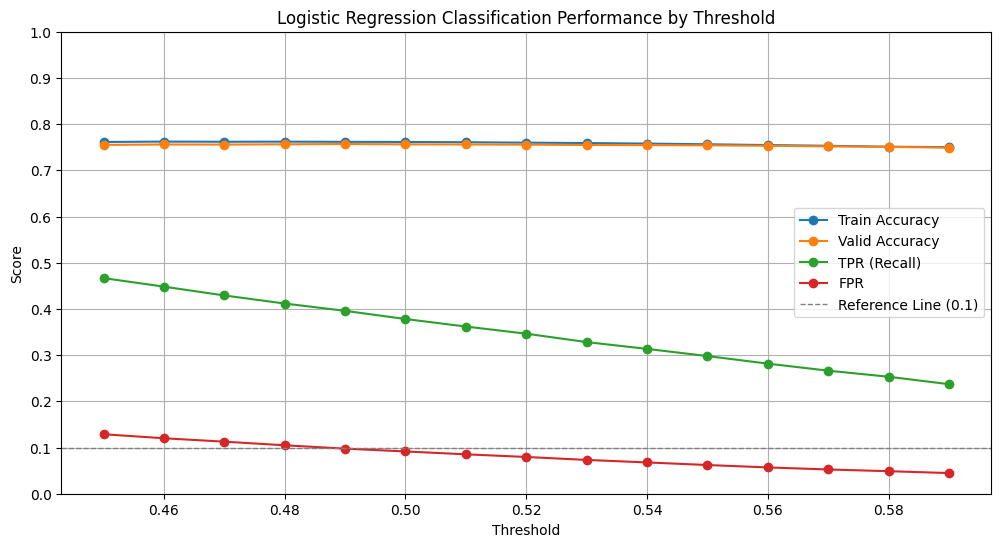

,Threshold,Train Accuracy,Valid Accuracy,TPR (Recall),FPR
0,0.45,0.761366,0.755078,0.466725,0.128714
1,0.46,0.762173,0.755910,0.448198,0.120079
2,0.47,0.761863,0.755729,0.429166,0.112663
3,0.48,0.762049,0.756272,0.411646,0.104841
4,0.49,0.761692,0.756924,0.395891,0.097577
5,0.50,0.761413,0.756164,0.378119,0.091482
6,0.51,0.760839,0.755910,0.361860,0.085285
7,0.52,0.759861,0.755548,0.346357,0.079545
8,0.53,0.759054,0.754897,0.328208,0.073145
9,0.54,0.757828,0.754535,0.313461,0.067710


In [62]:
# Define thresholds
thresholds = np.arange(0.45, 0.6, 0.01)

# Initialize results list
results = []

for threshold in thresholds:
    y_train_pred_binary = (y_train_proba >= threshold).astype(int)
    y_valid_pred_binary = (y_valid_proba >= threshold).astype(int)
    
    valid_acc = accuracy_score(y_valid_num, y_valid_pred_binary)
    train_acc = accuracy_score(y_train_num, y_train_pred_binary)

    cm = confusion_matrix(y_valid_num, y_valid_pred_binary)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    else:
        recall = np.nan
        fpr = np.nan

    results.append({
        'Threshold': threshold,
        'Train Accuracy': train_acc,
        'Valid Accuracy': valid_acc,
        'TPR (Recall)': recall,
        'FPR': fpr
    })

# Convert to DataFrame
lgr_threshold_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(lgr_threshold_df['Threshold'], lgr_threshold_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(lgr_threshold_df['Threshold'], lgr_threshold_df['Valid Accuracy'], label='Valid Accuracy', marker='o')
plt.plot(lgr_threshold_df['Threshold'], lgr_threshold_df['TPR (Recall)'], label='TPR (Recall)', marker='o')
plt.plot(lgr_threshold_df['Threshold'], lgr_threshold_df['FPR'], label='FPR', marker='o')

plt.yticks(np.arange(0.0, 1.05, 0.1))
plt.axhline(0.1, color='gray', linestyle='--', linewidth=1, label='Reference Line (0.1)')

plt.title("Logistic Regression Classification Performance by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()
lgr_threshold_df

In [63]:
# Save Logistic Regression results at threshold = 0.49
model_results = save_model_result(model_results, lgr_threshold_df, threshold=0.49, model_name="Logistic Regression")

# Print the result
last_row = model_results.iloc[-1]
print(f"{last_row['Model']} Final Results:")
print(f"Train Accuracy: {last_row['Train Accuracy']:.2%}")
print(f"Valid Accuracy:  {last_row['Test Accuracy']:.2%}")
print(f"TPR (Recall):   {last_row['TPR (Recall)']:.2%}")
print(f"FPR:            {last_row['FPR']:.2%}")
print(f"Threshold:      {last_row['Threshold']:.2f}")

Logistic Regression Final Results:
Train Accuracy: 76.17%
Valid Accuracy:  75.69%
TPR (Recall):   39.59%
FPR:            9.76%
Threshold:      0.49


### Cross Validation 

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

# Parameters
threshold = 0.5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics
accuracies = []
tprs = []
fprs = []

for train_index, valid_index in kfold.split(X_train_scaled, y_train_num):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[valid_index]
    y_tr, y_val = y_train_num.iloc[train_index], y_train_num.iloc[valid_index]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_tr, y_tr)

    # Predict probabilities
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
    else:
        tpr, fpr = 0, 0

    # Save
    accuracies.append(acc)
    tprs.append(tpr)
    fprs.append(fpr)

# --- Final results ---
print("\nCross-Validation Results (Logistic Regression):")
print(f"Avg Accuracy: {np.mean(accuracies):.4f}")
print(f"Avg TPR:      {np.mean(tprs):.4f}")
print(f"Avg FPR:      {np.mean(fprs):.4f}")




Cross-Validation Results (Logistic Regression):
Avg Accuracy: 0.7590
Avg TPR:      0.3902
Avg FPR:      0.0924


### 4.1.3 KNN

    k  Training Accuracy  Validation Accuracy  TPR (Recall)       FPR
0   1           0.999984             0.661851      0.384421  0.226342
1   3           0.831176             0.692806      0.338039  0.164220
2   5           0.792881             0.705550      0.301487  0.131610
3   6           0.771685             0.714746      0.186539  0.072383
4   7           0.776355             0.709207      0.273002  0.115000
5   8           0.762080             0.716267      0.185405  0.069792
6   9           0.766999             0.712719      0.255609  0.103063
7  10           0.756509             0.719525      0.184018  0.064662
8  20           0.743025             0.721335      0.159692  0.052319


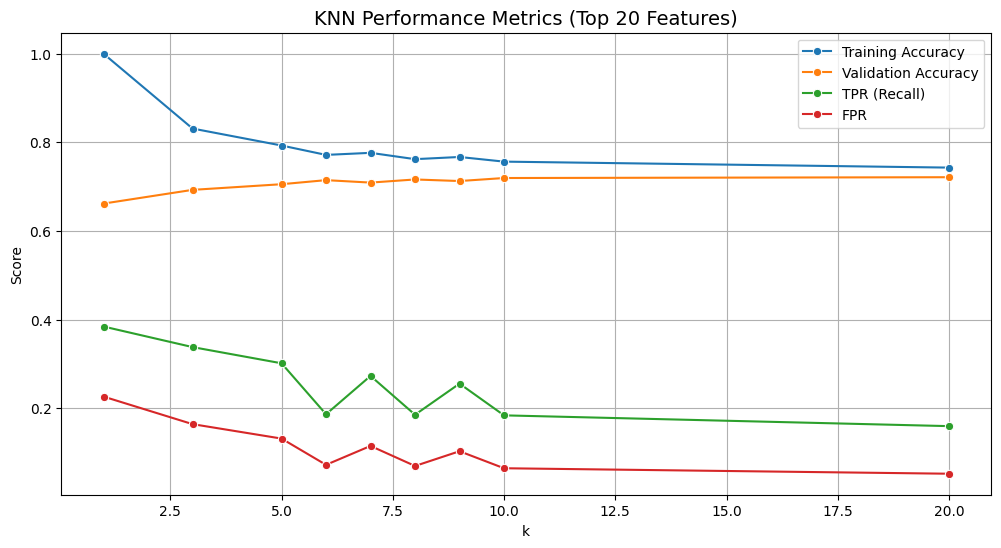

In [65]:
kvec = np.array([1, 3, 5, 6, 7, 8, 9, 10, 20])
va_acc = np.zeros(len(kvec))
tr_acc = np.zeros(len(kvec))
tpr = np.zeros(len(kvec))
fpr = np.zeros(len(kvec))

# Run KNN
for i, k in enumerate(kvec):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    y_train_pred = knn.predict(X_train_scaled)
    y_pred = knn.predict(X_valid_scaled)

    tr_acc[i] = accuracy_score(y_train, y_train_pred)
    va_acc[i] = accuracy_score(y_valid, y_pred)

    cm = confusion_matrix(y_valid, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    tpr[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr[i] = fp / (fp + tn) if (fp + tn) != 0 else 0

# Combine into DataFrame
results_df = pd.DataFrame({
    'k': kvec,
    'Training Accuracy': tr_acc,
    'Validation Accuracy': va_acc,
    'TPR (Recall)': tpr,
    'FPR': fpr
})

print(results_df)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='k', y='Training Accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=results_df, x='k', y='Validation Accuracy', label='Validation Accuracy', marker='o')
sns.lineplot(data=results_df, x='k', y='TPR (Recall)', label='TPR (Recall)', marker='o')
sns.lineplot(data=results_df, x='k', y='FPR', label='FPR', marker='o')
plt.title('KNN Performance Metrics (Top 20 Features)', fontsize=14)
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()

K=10 offers the best trade-off with strong validation accuracy (0.7195) and low false positive rate (0.0647), making it the optimal choice for balanced performance. We can optimise performance further by changiing the threshold

In [66]:
# Train KNN with k=10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predict probabilities for both train and valid sets
y_valid_proba = knn.predict_proba(X_valid_scaled)[:, 1]
y_train_proba = knn.predict_proba(X_train_scaled)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.3, 0.55, 0.03)

# Initialize metric lists
train_accuracies = []
valid_accuracies = []
recalls = []
fprs = []

# Evaluate performance at each threshold
for threshold in thresholds:
    # Binary predictions
    y_valid_pred = (y_valid_proba >= threshold).astype(int)
    y_train_pred = (y_train_proba >= threshold).astype(int)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    # Confusion matrix and metrics
    cm = confusion_matrix(y_valid, y_valid_pred)
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

    # Store metrics
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    recalls.append(recall)
    fprs.append(fpr)

# Combine into DataFrame
knn_threshold_results = pd.DataFrame({
    'Threshold': thresholds,
    'Train Accuracy': train_accuracies,
    'Valid Accuracy': valid_accuracies,
    'TPR (Recall)': recalls,
    'FPR': fprs
})

# Display
knn_threshold_results

,Threshold,Train Accuracy,Valid Accuracy,TPR (Recall),FPR
0,0.30,0.677001,0.606061,0.713259,0.437141
1,0.33,0.744235,0.673292,0.514621,0.262762
2,0.36,0.744235,0.673292,0.514621,0.262762
3,0.39,0.744235,0.673292,0.514621,0.262762
4,0.42,0.765416,0.707288,0.324679,0.138518
5,0.45,0.765416,0.707288,0.324679,0.138518
6,0.48,0.765416,0.707288,0.324679,0.138518
7,0.51,0.756509,0.719525,0.184018,0.064662
8,0.54,0.756509,0.719525,0.184018,0.064662


As shown in the table above, lowering the threshold below 0.51 increases recall (TPR) but also significantly raises the false positive rate (FPR). Conversely, higher thresholds maintain better precision and lower FPR but at the cost of recall.
Threshold ≈ 0.51 offers a strong balance

In [67]:
# Save KNN results at threshold = 0.51
model_results = save_model_result(model_results, knn_threshold_results, threshold=0.51, model_name="K-Nearest Neighbour")

# Print the result
last_row = model_results.iloc[-1]
print(f"{last_row['Model']} Final Results:")
print(f"Train Accuracy: {last_row['Train Accuracy']:.2%}")
print(f"Valid Accuracy:  {last_row['Test Accuracy']:.2%}")
print(f"TPR (Recall):   {last_row['TPR (Recall)']:.2%}")
print(f"FPR:            {last_row['FPR']:.2%}")
print(f"Threshold:      {last_row['Threshold']:.2f}")

K-Nearest Neighbour Final Results:
Train Accuracy: 75.65%
Valid Accuracy:  71.95%
TPR (Recall):   18.40%
FPR:            6.47%
Threshold:      0.51


While we see good generalisation performance the TPR needs to be improved, so trying Decision trees next.

### 4.1.4 Decision Trees

In [68]:
# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)

# Predict and evaluate
y_train_pred = dt.predict(X_train_scaled)
y_valid_pred = dt.predict(X_valid_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

cm = confusion_matrix(y_valid, y_valid_pred)

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
print("Decision Tree Results:")
print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Valid Accuracy:  {valid_accuracy:.2%}")
print(f"TPR (Recall):   {tpr:.2%}")
print(f"FPR:            {fpr:.2%}")

Decision Tree Results:
Train Accuracy: 74.79%
Valid Accuracy:  74.72%
TPR (Recall):   34.94%
FPR:            9.24%


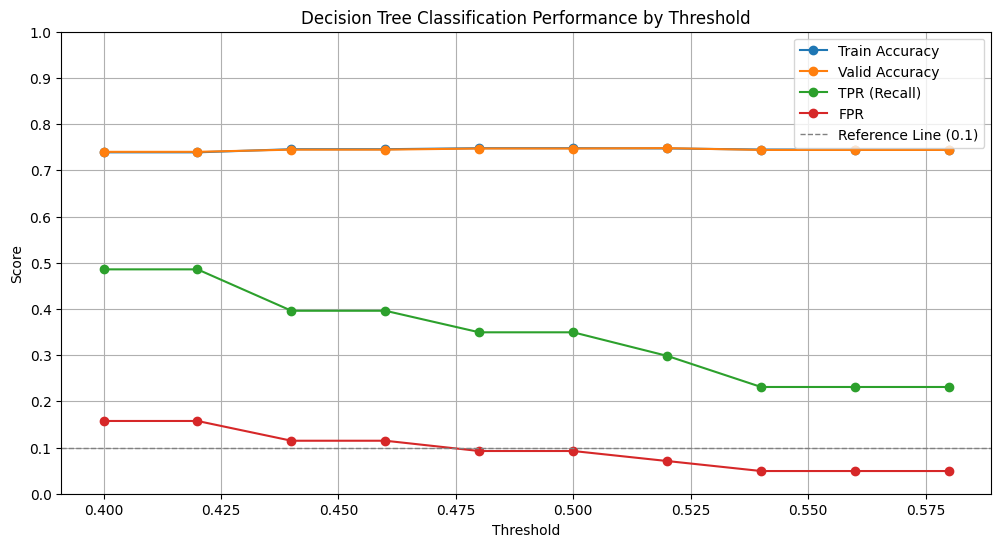

,Threshold,Train Accuracy,Valid Accuracy,TPR (Recall),FPR
0,0.40,0.738929,0.740017,0.485631,0.157464
1,0.42,0.738929,0.740017,0.485631,0.157464
2,0.44,0.745710,0.744759,0.396017,0.114695
3,0.46,0.745710,0.744759,0.396017,0.114695
4,0.48,0.747897,0.747221,0.349382,0.092447
5,0.50,0.747897,0.747221,0.349382,0.092447
6,0.52,0.747385,0.748018,0.298336,0.070757
7,0.54,0.744996,0.744108,0.231031,0.049119
8,0.56,0.744996,0.744108,0.231031,0.049119
9,0.58,0.744996,0.744108,0.231031,0.049119


In [69]:
# Get predicted probabilities (class 1)
y_train_proba = dt.predict_proba(X_train_scaled)[:, 1]
y_valid_proba = dt.predict_proba(X_valid_scaled)[:, 1]

# Define thresholds
thresholds = np.arange(0.4, 0.6, 0.02)

# Store metrics
results = []

for threshold in thresholds:
    # Apply threshold to probabilities
    y_train_bin = (y_train_proba >= threshold).astype(int)
    y_valid_bin = (y_valid_proba >= threshold).astype(int)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_bin)
    valid_acc = accuracy_score(y_valid, y_valid_bin)

    # Confusion Matrix
    cm = confusion_matrix(y_valid, y_valid_bin)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    else:
        recall = np.nan
        fpr = np.nan

    # Save results
    results.append({
        'Threshold': threshold,
        'Train Accuracy': train_acc,
        'Valid Accuracy': valid_acc,
        'TPR (Recall)': recall,
        'FPR': fpr
    })

# Convert to DataFrame
dt_threshold_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dt_threshold_df['Threshold'], dt_threshold_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(dt_threshold_df['Threshold'], dt_threshold_df['Valid Accuracy'], label='Valid Accuracy', marker='o')
plt.plot(dt_threshold_df['Threshold'], dt_threshold_df['TPR (Recall)'], label='TPR (Recall)', marker='o')
plt.plot(dt_threshold_df['Threshold'], dt_threshold_df['FPR'], label='FPR', marker='o')

plt.yticks(np.arange(0.0, 1.05, 0.1))
plt.axhline(0.1, color='gray', linestyle='--', linewidth=1, label='Reference Line (0.1)')

plt.title("Decision Tree Classification Performance by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()

# Results
dt_threshold_df

In [70]:
# Save Decision Tree results at threshold = 0.48
model_results = save_model_result(model_results, dt_threshold_df, threshold=0.48, model_name="Decision Tree")

# Print the result
last_row = model_results.iloc[-1]
print(f"{last_row['Model']} Final Results:")
print(f"Train Accuracy: {last_row['Train Accuracy']:.2%}")
print(f"Valid Accuracy:  {last_row['Test Accuracy']:.2%}")
print(f"TPR (Recall):   {last_row['TPR (Recall)']:.2%}")
print(f"FPR:            {last_row['FPR']:.2%}")
print(f"Threshold:      {last_row['Threshold']:.2f}")

Decision Tree Final Results:
Train Accuracy: 74.79%
Valid Accuracy:  74.72%
TPR (Recall):   34.94%
FPR:            9.24%
Threshold:      0.48


### 4.1.5 Random Forest 

In [71]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_train_pred = rf.predict(X_train_scaled)
y_valid_pred = rf.predict(X_valid_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

cm = confusion_matrix(y_valid, y_valid_pred)

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
print("Random Forest Results:")
print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Valid Accuracy:  {valid_accuracy:.2%}")
print(f"TPR (Recall):   {tpr:.2%}")
print(f"FPR:            {fpr:.2%}")

Random Forest Results:
Train Accuracy: 100.00%
Valid Accuracy:  75.01%
TPR (Recall):   26.08%
FPR:            5.27%


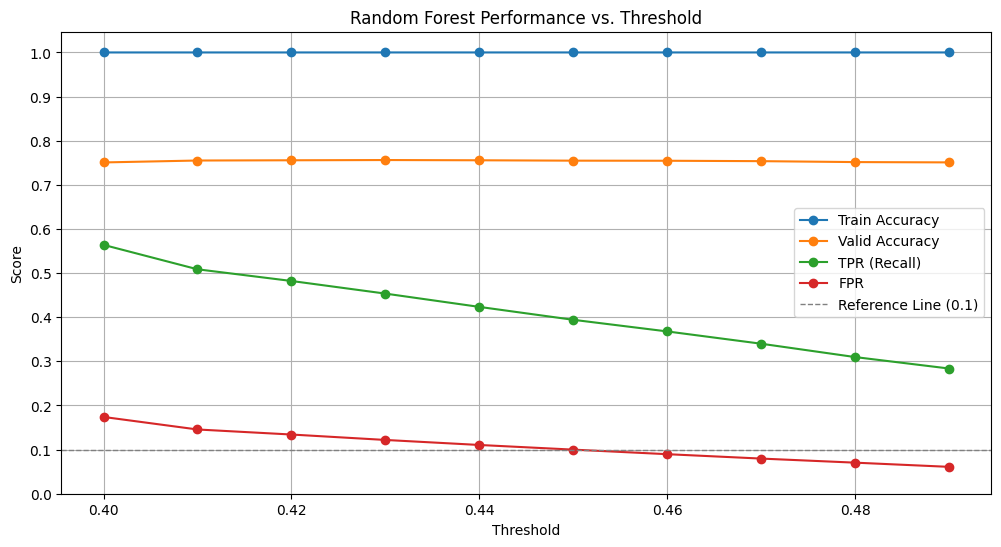

,Threshold,Train Accuracy,Valid Accuracy,TPR (Recall),FPR
0,0.40,0.999969,0.750733,0.563902,0.173973
1,0.41,0.999969,0.755078,0.508571,0.145578
2,0.42,0.999969,0.755621,0.482102,0.134149
3,0.43,0.999984,0.756164,0.453491,0.121857
4,0.44,0.999984,0.755621,0.423368,0.110479
5,0.45,0.999984,0.754752,0.394127,0.099914
6,0.46,0.999984,0.754535,0.367784,0.089602
7,0.47,0.999984,0.753629,0.339929,0.079646
8,0.48,0.999984,0.751530,0.309680,0.070402
9,0.49,0.999984,0.750842,0.283716,0.060903


In [72]:
## Plotting for different values of threshold
# Get predicted probabilities for positive class
y_valid_proba = rf.predict_proba(X_valid_scaled)[:, 1]
y_train_proba = rf.predict_proba(X_train_scaled)[:, 1]

# Define thresholds
thresholds = np.arange(0.4, 0.5, 0.01)

results = []

for threshold in thresholds:
    # Predict with custom threshold
    y_valid_pred_thresh = (y_valid_proba >= threshold).astype(int)
    y_train_pred_thresh = (y_train_proba >= threshold).astype(int)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred_thresh)
    valid_acc = accuracy_score(y_valid, y_valid_pred_thresh)

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_valid_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

    results.append({
        'Threshold': threshold,
        'Train Accuracy': train_acc,
        'Valid Accuracy': valid_acc,
        'TPR (Recall)': recall,
        'FPR': fpr
    })

rf_threshold_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(rf_threshold_df['Threshold'], rf_threshold_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(rf_threshold_df['Threshold'], rf_threshold_df['Valid Accuracy'], label='Valid Accuracy', marker='o')
plt.plot(rf_threshold_df['Threshold'], rf_threshold_df['TPR (Recall)'], label='TPR (Recall)', marker='o')
plt.plot(rf_threshold_df['Threshold'], rf_threshold_df['FPR'], label='FPR', marker='o')

# Customize y-axis ticks
plt.yticks(np.arange(0.0, 1.05, 0.1))

# Add horizontal reference line at y=0.1
plt.axhline(y=0.1, color='gray', linestyle='--', linewidth=1, label='Reference Line (0.1)')

plt.title('Random Forest Performance vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()
rf_threshold_df

Threshold = 0.46 gives us the best result for FPR below 10% and TPR = 36.90% 

In [73]:
# Save Random Forest results at threshold = 0.46
model_results = save_model_result(model_results, rf_threshold_df, threshold=0.46, model_name="Random Forest")

# Print the result
last_row = model_results.iloc[-1]
print(f"{last_row['Model']} Final Results:")
print(f"Train Accuracy: {last_row['Train Accuracy']:.2%}")
print(f"Valid Accuracy:  {last_row['Test Accuracy']:.2%}")
print(f"TPR (Recall):   {last_row['TPR (Recall)']:.2%}")
print(f"FPR:            {last_row['FPR']:.2%}")
print(f"Threshold:      {last_row['Threshold']:.2f}")

Random Forest Final Results:
Train Accuracy: 100.00%
Valid Accuracy:  75.45%
TPR (Recall):   36.78%
FPR:            8.96%
Threshold:      0.46


In [74]:
model_results

,Model,Train Accuracy,Test Accuracy,TPR (Recall),FPR,Threshold
0,Linear Regression,0.756649,0.751711,0.366776,0.093158,0.47
1,Logistic Regression,0.761692,0.756924,0.395891,0.097577,0.49
2,K-Nearest Neighbour,0.756509,0.719525,0.184018,0.064662,0.51
3,Decision Tree,0.747897,0.747221,0.349382,0.092447,0.48
4,Random Forest,0.999984,0.754535,0.367784,0.089602,0.46


We evaluated five baseline models, with Logistic Regression achieving the best balance of validation accuracy (75.66%) and recall (39.44%) at a 0.49 threshold.